<a href="https://colab.research.google.com/github/MN589/Data-Science-and-ML-Project-Portfolio/blob/main/BoE_Project_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NOTES
* Need to further clean features
* Need to create some lagged features / composites
* Test other models (other than RF)
* Hyperparameter tuning

## 0) Import Packages

In [ ]:
# API key

alphavantage_api_key = '43HVNM70CFAV60F7'

In [ ]:
# Global Import
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
import shap
import warnings

from scipy.stats import randint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:
# Set display options so full data shows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
# Mount Gdrive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Global functions

In [ ]:
# Function for turning date columns into date and all other columns as float

def convert_dates_and_floats(df):
    df = df.copy()  # avoid modifying original df

    for col in df.columns:
        # Try to convert to datetime first
        try:
            df[col] = pd.to_datetime(df[col],format='%Y-%m-%d', errors='raise')
        except Exception:
            # If conversion to datetime fails, convert to float
            try:
                df[col] = df[col].astype(float)
            except Exception:
                # If conversion to float also fails, keep as is (or handle differently)
                pass

    return df

In [ ]:
# Function for lagging fiscal end date

def lag_fiscal_end_date(df):
    """
    Lags the fiscalDateEnding column by 3 months for df.
    """
    df = df.copy()
    df['fiscalDateEnding'] = df['fiscalDateEnding'] + pd.DateOffset(months=3) + pd.offsets.MonthEnd(0) # Ensures we offset to month end for 31D months
    return df

## 1) Alphavantage Load Data

### 1.1) Alphavantage functions

Alphavantage API documentation https://www.alphavantage.co/documentation/

In [ ]:
# Using the Alphavantage URL

def get_data(function, ticker, api_key = alphavantage_api_key):
  """get data from alphavantage api"""
  url = f'https://www.alphavantage.co/query?function={function}&symbol={ticker}&apikey={api_key}'
  r = requests.get(url)
  data = r.json()
  return data

### 1.2) Earnings Data

In [ ]:
# Citi quarterly earnings 2014Q1 to 2025Q1

data = get_data(function='EARNINGS', ticker='C')
quarterly_earnings_citi = pd.DataFrame(data['quarterlyEarnings'])
quarterly_earnings_citi = quarterly_earnings_citi[(quarterly_earnings_citi['fiscalDateEnding'] >= '2014-03-31') & (quarterly_earnings_citi['fiscalDateEnding'] <= '2025-03-31')]
display(quarterly_earnings_citi)

fiscalDateEnding reportedDate reportedEPS estimatedEPS surprise  \
0        2025-03-31   2025-04-15        1.96         1.85     0.11   
1        2024-12-31   2025-01-15        1.34         1.22     0.12   
2        2024-09-30   2024-10-15        1.51         1.31      0.2   
3        2024-06-30   2024-07-12        1.52         1.39     0.13   
4        2024-03-31   2024-04-12        1.86         1.23     0.63   
5        2023-12-31   2024-01-12        0.84         0.81     0.03   
6        2023-09-30   2023-10-13        1.52         1.21     0.31   
7        2023-06-30   2023-07-14        1.37          1.3     0.07   
8        2023-03-31   2023-04-14        1.86         1.67     0.19   
9        2022-12-31   2023-01-13         1.1         1.14    -0.04   
10       2022-09-30   2022-10-14         1.5         1.42     0.08   
11       2022-06-30   2022-07-15         2.3         1.68     0.62   
12       2022-03-31   2022-04-14        2.31         1.55     0.76   
13       2021-12-31   2022-01-14        1.46         1.38     0.08   
14       2021-09-30   2021-10-14        2.15         1.65      0.5   
15       2021-06-30   2021-07-14        2.63         1.96     0.67   
16       2021-03-31   2021-04-15        3.62          2.6     1.02   
17       2020-12-31   2021-01-15        2.08         1.34     0.74   
18       2020-09-30   2020-10-13        1.55         0.93     0.62   
19       2020-06-30   2020-07-14         0.5         0.28     0.22   
20       2020-03-31   2020-04-15        1.05         1.04     0.01   
21       2019-12-31   2020-01-14        2.15         1.84     0.31   
22       2019-09-30   2019-10-15        1.99         1.95     0.04   
23       2019-06-30   2019-07-15        1.83          1.8     0.03   
24       2019-03-31   2019-04-15        1.87          1.8     0.07   
25       2018-12-31   2019-01-14        1.61         1.55     0.06   
26       2018-09-30   2018-10-12        1.73         1.69     0.04   
27       2018-06-30   2018-07-13        1.63         1.56     0.07   
28       2018-03-31   2018-04-13        1.68         1.61     0.07   
29       2017-12-31   2018-01-16        1.28         1.19     0.09   
30       2017-09-30   2017-10-12        1.42         1.32      0.1   
31       2017-06-30   2017-07-14        1.28         1.21     0.07   
32       2017-03-31   2017-04-13        1.35         1.24     0.11   
33       2016-12-31   2017-01-18        1.14         1.12     0.02   
34       2016-09-30   2016-10-14        1.24         1.16     0.08   
35       2016-06-30   2016-07-15        1.24          1.1     0.14   
36       2016-03-31   2016-04-15         1.1         1.03     0.07   
37       2015-12-31   2016-01-15        1.06         1.05     0.01   
38       2015-09-30   2015-10-15        1.31         1.28     0.03   
39       2015-06-30   2015-07-16        1.45         1.34     0.11   
40       2015-03-31   2015-04-16        1.52         1.39     0.13   
41       2014-12-31   2015-01-15        0.06         0.09    -0.03   
42       2014-09-30   2014-10-14        1.15         1.12     0.03   
43       2014-06-30   2014-07-14        1.24         1.05     0.19   
44       2014-03-31   2014-04-14         1.3         1.14     0.16   

   surprisePercentage  reportTime  
0              5.9459  pre-market  
1              9.8361  pre-market  
2             15.2672  pre-market  
3              9.3525  pre-market  
4             51.2195  pre-market  
5              3.7037  pre-market  
6             25.6198  pre-market  
7              5.3846  pre-market  
8             11.3772  pre-market  
9             -3.5088  pre-market  
10             5.6338  pre-market  
11            36.9048  pre-market  
12            49.0323  pre-market  
13             5.7971  pre-market  
14             30.303  pre-market  
15            34.1837  pre-market  
16            39.2308  pre-market  
17            55.2239  pre-market  
18            66.6667  pre-market  
19            78.5714  pre-market  
20             0.9615  pre

In [ ]:
# Value counts of citi surprise EPS pct

quarterly_earnings_citi['surprisePercentage'].value_counts().sort_index()

surprisePercentage
-3.5088     1
-33.3333    1
0.9524      1
0.9615      1
1.6667      1
1.7857      1
11.3772     1
12.7273     1
14.0351     1
15.2672     1
16.8478     1
18.0952     1
2.0513      1
2.3438      1
2.3669      1
2.6786      1
25.6198     1
3.7037      1
3.871       1
3.8889      1
30.303      1
34.1837     1
36.9048     1
39.2308     1
4.3478      1
4.4872      1
49.0323     1
5.3846      1
5.6338      1
5.7851      1
5.7971      1
5.9459      1
51.2195     1
55.2239     1
6.7961      1
6.8966      1
66.6667     1
7.563       1
7.5758      1
78.5714     1
8.209       1
8.871       1
9.3525      2
9.8361      1
Name: count, dtype: int64

In [ ]:
# JPMorgan quarterly earnings 2014Q1 to 2025Q1

data = get_data(function='EARNINGS', ticker='JPM')
quarterly_earnings_jpm = pd.DataFrame(data['quarterlyEarnings'])
quarterly_earnings_jpm = quarterly_earnings_jpm[(quarterly_earnings_jpm['fiscalDateEnding'] >= '2014-03-31') & (quarterly_earnings_jpm['fiscalDateEnding'] <= '2025-03-31')]
display(quarterly_earnings_jpm)

fiscalDateEnding reportedDate reportedEPS estimatedEPS surprise  \
0        2025-03-31   2025-04-11        4.91         4.61      0.3   
1        2024-12-31   2025-01-15        4.81         4.11      0.7   
2        2024-09-30   2024-10-11        4.37         4.01     0.36   
3        2024-06-30   2024-07-12        4.26         4.19     0.07   
4        2024-03-31   2024-04-12        4.44         4.11     0.33   
5        2023-12-31   2024-01-12        3.04         3.32    -0.28   
6        2023-09-30   2023-10-13        4.33         3.96     0.37   
7        2023-06-30   2023-07-14        4.75            4     0.75   
8        2023-03-31   2023-04-14         4.1         3.41     0.69   
9        2022-12-31   2023-01-13        3.56         3.07     0.49   
10       2022-09-30   2022-10-14        3.36         2.88     0.48   
11       2022-06-30   2022-07-14        2.76         2.88    -0.12   
12       2022-03-31   2022-04-13        2.76         2.69     0.07   
13       2021-12-31   2022-01-14        3.33         3.01     0.32   
14       2021-09-30   2021-10-13        3.74            3     0.74   
15       2021-06-30   2021-07-13        3.78         3.21     0.57   
16       2021-03-31   2021-04-14        4.59          3.1     1.49   
17       2020-12-31   2021-01-15        3.79         2.62     1.17   
18       2020-09-30   2020-10-13        2.92         2.23     0.69   
19       2020-06-30   2020-07-14        1.38         1.04     0.34   
20       2020-03-31   2020-04-14        0.78         1.84    -1.06   
21       2019-12-31   2020-01-14        2.57         2.35     0.22   
22       2019-09-30   2019-10-15        2.68         2.45     0.23   
23       2019-06-30   2019-07-16        2.51          2.5     0.01   
24       2019-03-31   2019-04-12        2.65         2.35      0.3   
25       2018-12-31   2019-01-15        1.98          2.2    -0.22   
26       2018-09-30   2018-10-12        2.34         2.25     0.09   
27       2018-06-30   2018-07-13        2.29         2.22     0.07   
28       2018-03-31   2018-04-13        2.26         2.28    -0.02   
29       2017-12-31   2018-01-12        1.76         1.69     0.07   
30       2017-09-30   2017-10-12        1.76         1.65     0.11   
31       2017-06-30   2017-07-14        1.71         1.58     0.13   
32       2017-03-31   2017-04-13        1.65         1.52     0.13   
33       2016-12-31   2017-01-13        1.58         1.44     0.14   
34       2016-09-30   2016-10-14        1.58         1.39     0.19   
35       2016-06-30   2016-07-14        1.55         1.43     0.12   
36       2016-03-31   2016-04-13        1.35         1.26     0.09   
37       2015-12-31   2016-01-14        1.32         1.25     0.07   
38       2015-09-30   2015-10-13        1.68         1.37     0.31   
39       2015-06-30   2015-07-14        1.54         1.44      0.1   
40       2015-03-31   2015-04-14        1.45          1.4     0.05   
41       2014-12-31   2015-01-14        1.19         1.31    -0.12   
42       2014-09-30   2014-10-14        1.36         1.38    -0.02   
43       2014-06-30   2014-07-15        1.46         1.29     0.17   
44       2014-03-31   2014-04-11        1.28          1.4    -0.12   

   surprisePercentage   reportTime  
0              6.5076   pre-market  
1             17.0316   pre-market  
2              8.9776   pre-market  
3              1.6706   pre-market  
4              8.0292   pre-market  
5             -8.4337   pre-market  
6              9.3434   pre-market  
7               18.75   pre-market  
8             20.2346   pre-market  
9             15.9609   pre-market  
10            16.6667   pre-market  
11            -4.1667   pre-market  
12             2.6022   pre-market  
13            10.6312   pre-market  
14            24.6667   pre-market  
15             17.757   pre-market  
16            48.0645   pre-market  
17            44.6565   pre-market  
18            30.9417   pre-market  
19            32.6923   pre-market  
20   

In [ ]:
# Value counts of jpm surprise EPS pct

quarterly_earnings_jpm['surprisePercentage'].value_counts().sort_index()

surprisePercentage
-0.8772     1
-1.4493     1
-10         1
-4.1667     1
-57.6087    1
-8.4337     1
-8.5714     1
-9.1603     1
0.4         1
1.6706      1
10.6312     1
12.766      1
13.1783     1
13.6691     1
15.9609     1
16.6667     1
17.0316     1
17.757      1
18.75       1
2.6022      1
20.2346     1
22.6277     1
24.6667     1
3.1532      1
3.5714      1
30.9417     1
32.6923     1
4           1
4.142       1
44.6565     1
48.0645     1
5.6         1
6.5076      1
6.6667      1
6.9444      1
7.1429      1
8.0292      1
8.2278      1
8.3916      1
8.5526      1
8.9776      1
9.3434      1
9.3617      1
9.3878      1
9.7222      1
Name: count, dtype: int64

### 1.3) Income Statement

In [ ]:
# Citi income statement 2014Q1 to 2025Q1

data = get_data(function='INCOME_STATEMENT', ticker='C')
quarterly_income_statement_citi = pd.DataFrame(data['quarterlyReports'])
quarterly_income_statement_citi = quarterly_income_statement_citi[(quarterly_income_statement_citi['fiscalDateEnding'] >= '2014-03-31') & (quarterly_income_statement_citi['fiscalDateEnding'] <= '2025-03-31')]
display(quarterly_income_statement_citi)

fiscalDateEnding reportedCurrency  grossProfit totalRevenue costOfRevenue  \
0        2025-03-31              USD  18893000000  41255000000   22362000000   
1        2024-12-31              USD  17005000000  40900000000   23895000000   
2        2024-09-30              USD  17668000000  43359000000   25691000000   
3        2024-06-30              USD  17681000000  42638000000   24957000000   
4        2024-03-31              USD  18678000000  43722000000   25044000000   
5        2023-12-31              USD  15317000000  41395000000   26078000000   
6        2023-09-30              USD  17921000000  40748000000   22827000000   
7        2023-06-30              USD  17626000000  38187000000   20561000000   
8        2023-03-31              USD  18437000000  36452000000   18015000000   
9        2022-12-31              USD  16181000000  30439000000   14258000000   
10       2022-09-30              USD  16554000000  25240000000    8686000000   
11       2022-06-30              USD  18338000000  23236000000    4898000000   
12       2022-03-31              USD  18458000000  21468000000    3010000000   
13       2021-12-31              USD  17741000000  18332000000     591000000   
14       2021-09-30              USD  17661000000  19416000000    1755000000   
15       2021-06-30              USD  18834000000  19734000000     900000000   
16       2021-03-31              USD  21157000000  21706000000     -68000000   
17       2020-12-31              USD  16212000000  19077000000    2865000000   
18       2020-09-30              USD  14976000000  20139000000    5163000000   
19       2020-06-30              USD  11584000000  23244000000   11660000000   
20       2020-03-31              USD  14348000000  26646000000    8543000000   
21       2019-12-31              USD  16181000000  24926000000    8745000000   
22       2019-09-30              USD  16505000000  26112000000    9607000000   
23       2019-06-30              USD  16684000000  26520000000    9836000000   
24       2019-03-31              USD  16608000000  25893000000    9285000000   
25       2018-12-31              USD  15227000000  23977000000    8750000000   
26       2018-09-30              USD  16441000000  24757000000    8316000000   
27       2018-06-30              USD  16678000000  24354000000    7676000000   
28       2018-03-31              USD  17041000000  24032000000    6991000000   
29       2017-12-31              USD  15210000000  21791000000    6581000000   
30       2017-09-30              USD  16448000000  22798000000    6350000000   
31       2017-06-30              USD  16573000000  22303000000    5730000000   
32       2017-03-31              USD  16734000000  21932000000    5198000000   
33       2016-12-31              USD  15252000000  20289000000    5037000000   
34       2016-09-30              USD  16059000000  20934000000    4875000000   
35       2016-06-30              USD  16188000000  20668000000    4480000000   
36       2016-03-31              USD  15598000000  20495000000    4897000000   
37       2015-12-31              USD  16106000000  21357000000    5251000000   
38       2015-09-30              USD  17045000000  21633000000    4588000000   
39       2015-06-30              USD  18003000000  22521000000    4518000000   
40       2015-03-31              USD  18018000000  22764000000    4746000000   
41       2014-12-31              USD  16600000000  20971000000    4371000000   
42       2014-09-30              USD  18144000000  23014000000    4870000000   
43       2014-06-30              USD  17877000000  23040000000    5163000000   
44       2014-03-31              USD  18440000000  23797000000    5357000000   

   costofGoodsAndServicesSold operatingIncome sellingGeneralAndAdministrative  \
0                 22362000000      5448000000                      7484000000   
1                 23895000000      4842000000                      6940000000   
2                 25691000000      4390000000                      7086000000  

In [ ]:
# JPM income statement 2014Q1 to 2025Q1

data = get_data(function='INCOME_STATEMENT', ticker='JPM')
quarterly_income_statement_jpm = pd.DataFrame(data['quarterlyReports'])
quarterly_income_statement_jpm = quarterly_income_statement_jpm[(quarterly_income_statement_jpm['fiscalDateEnding'] >= '2014-03-31') & (quarterly_income_statement_jpm['fiscalDateEnding'] <= '2025-03-31')]
display(quarterly_income_statement_jpm)

fiscalDateEnding reportedCurrency  grossProfit totalRevenue costOfRevenue  \
0        2025-03-31              USD  42005000000  68907000000   26902000000   
1        2024-12-31              USD  40137000000  67007000000   26870000000   
2        2024-09-30              USD  39543000000  69667000000   30124000000   
3        2024-06-30              USD  39039000000  67835000000   28796000000   
4        2024-03-31              USD  40050000000  66264000000   26214000000   
5        2023-12-31              USD  35849000000  61933000000   26084000000   
6        2023-09-30              USD  38390000000  61591000000   23201000000   
7        2023-06-30              USD  35696000000  58447000000   22751000000   
8        2023-03-31              USD  36074000000  54641000000   18567000000   
9        2022-12-31              USD  32259000000  34547000000   15115000000   
10       2022-09-30              USD  29188000000  32716000000    3528000000   
11       2022-06-30              USD  29614000000  34227000000    4613000000   
12       2022-03-31              USD  29254000000  32342000000    3088000000   
13       2021-12-31              USD  30545000000  30706000000     161000000   
14       2021-09-30              USD  31174000000  31061000000    -113000000   
15       2021-06-30              USD  32764000000  31839000000    -925000000   
16       2021-03-31              USD  36422000000  33632000000   -2790000000   
17       2020-12-31              USD  31113000000  30558000000    -555000000   
18       2020-09-30              USD  28644000000  30845000000    2201000000   
19       2020-06-30              USD  22602000000  35330000000   12728000000   
20       2020-03-31              USD  24607000000  31955000000   12998000000   
21       2019-12-31              USD  26904000000  34092000000    7188000000   
22       2019-09-30              USD  27777000000  35717000000    8407000000   
23       2019-06-30              USD  27598000000  35462000000    8354000000   
24       2019-03-31              USD  27628000000  36059000000    8431000000   
25       2018-12-31              USD  24561000000  32793000000    8232000000   
26       2018-09-30              USD  26312000000  32791000000    6479000000   
27       2018-06-30              USD  26543000000  33255000000    6291000000   
28       2018-03-31              USD  24965000000  32290000000    5548000000   
29       2017-12-31              USD  22845000000  28119000000    5274000000   
30       2017-09-30              USD  24126000000  29467000000    5341000000   
31       2017-06-30              USD  23871000000  28528000000    4657000000   
32       2017-03-31              USD  23624000000  27917000000    4293000000   
33       2016-12-31              USD  22512000000  26089000000    3577000000   
34       2016-09-30              USD  23402000000  27140000000    3738000000   
35       2016-06-30              USD  22978000000  26846000000    3868000000   
36       2016-03-31              USD  21415000000  23239000000    2501000000   
37       2015-12-31              USD  21120000000  24301000000    3181000000   
38       2015-09-30              USD  22098000000  24595000000    2497000000   
39       2015-06-30              USD  22877000000  25642000000    2765000000   
40       2015-03-31              USD  23107000000  25954000000    2847000000   
41       2014-12-31              USD  21672000000  24401000000    2729000000   
42       2014-09-30              USD  23712000000  26288000000    2576000000   
43       2014-06-30              USD  23986000000  26741000000    2755000000   
44       2014-03-31              USD  22365000000  25341000000    2976000000   

   costofGoodsAndServicesSold operatingIncome sellingGeneralAndAdministrative  \
0                 26902000000     18408000000                     14427000000   
1                 26870000000     17375000000                     12469000000   
2                 30124000000     16978000000                     12817000000  

### 1.4) Balance Sheet

In [ ]:
# Citi balance sheet 2014Q1 to 2025Q1

data = get_data(function='BALANCE_SHEET', ticker='C')
quarterly_balance_sheet_citi = pd.DataFrame(data['quarterlyReports'])
quarterly_balance_sheet_citi = quarterly_balance_sheet_citi[(quarterly_balance_sheet_citi['fiscalDateEnding'] >= '2014-03-31') & (quarterly_balance_sheet_citi['fiscalDateEnding'] <= '2025-03-31')]
display(quarterly_balance_sheet_citi)

fiscalDateEnding reportedCurrency    totalAssets totalCurrentAssets  \
0        2025-03-31              USD  2571514000000      1267646000000   
1        2024-12-31              USD  2352945000000      1072653000000   
2        2024-09-30              USD  2430663000000      1127142000000   
3        2024-06-30              USD  2405686000000      1111402000000   
4        2024-03-31              USD  2432510000000      1134433000000   
5        2023-12-31              USD  2411834000000      1120490000000   
6        2023-09-30              USD  2368477000000      1108994000000   
7        2023-06-30              USD  2423675000000      1171368000000   
8        2023-03-31              USD  2455113000000      1209336000000   
9        2022-12-31              USD  2416676000000      1201297000000   
10       2022-09-30              USD  2381064000000       604373000000   
11       2022-06-30              USD  2380904000000       596377000000   
12       2022-03-31              USD  2394105000000      1176418000000   
13       2021-12-31              USD  2291413000000      1121529000000   
14       2021-09-30              USD  2361876000000       670655000000   
15       2021-06-30              USD  2327868000000       656236000000   
16       2021-03-31              USD  2314266000000      1183644000000   
17       2020-12-31              USD  2260321000000       684322000000   
18       2020-09-30              USD  2234459000000      1190906000000   
19       2020-06-30              USD  2232715000000       698316000000   
20       2020-03-31              USD  2219770000000       654765000000   
21       2019-12-31              USD  1951158000000       506705000000   
22       2019-09-30              USD  2014802000000       541656000000   
23       2019-06-30              USD  1988226000000       517694000000   
24       2019-03-31              USD  1958413000000       513932000000   
25       2018-12-31              USD  1917288000000       503885000000   
26       2018-09-30              USD  1925165000000       518521000000   
27       2018-06-30              USD  1912334000000       520648000000   
28       2018-03-31              USD  1922104000000       528179000000   
29       2017-12-31              USD  1843059000000       502057000000   
30       2017-09-30              USD  1889133000000       511687000000   
31       2017-06-30              USD  1864063000000       513468000000   
32       2017-03-31              USD  1821635000000       500947000000   
33       2016-12-31              USD  1792077000000       482416000000   
34       2016-09-30              USD  1818117000000       493694000000   
35       2016-06-30              USD  1818771000000       493031000000   
36       2016-03-31              USD  1800967000000       494166000000   
37       2015-12-31              USD  1731210000000       451663000000   
38       2015-09-30              USD  1808356000000       486582000000   
39       2015-06-30              USD  1827095000000       483485000000   
40       2015-03-31              USD  1831801000000       476680000000   
41       2014-12-31              USD  1842530000000       477674000000   
42       2014-09-30              USD  1882849000000       519831000000   
43       2014-06-30              USD  1910270000000       526360000000   
44       2014-03-31              USD  1894736000000       530673000000   

   cashAndCashEquivalentsAtCarryingValue cashAndShortTermInvestments  \
0                           308331000000                308331000000   
1                           276532000000                276532000000   
2                           303094000000                303094000000   
3                           246134000000                246134000000   
4                           272730000000                272730000000   
5                           260932000000                260932000000   
6                           253987000000                253987000000   
7                     

In [ ]:
# JPM balance sheet 2014Q1 to 2025Q1

data = get_data(function='BALANCE_SHEET', ticker='JPM')
quarterly_balance_sheet_jpm = pd.DataFrame(data['quarterlyReports'])
quarterly_balance_sheet_jpm = quarterly_balance_sheet_jpm[(quarterly_balance_sheet_jpm['fiscalDateEnding'] >= '2014-03-31') & (quarterly_balance_sheet_jpm['fiscalDateEnding'] <= '2025-03-31')]
display(quarterly_balance_sheet_jpm)

fiscalDateEnding reportedCurrency    totalAssets totalCurrentAssets  \
0        2025-03-31              USD  4357856000000      2013430000000   
1        2024-12-31              USD  4002814000000      1763945000000   
2        2024-09-30              USD  4210048000000      1895172000000   
3        2024-06-30              USD  4143003000000      1873726000000   
4        2024-03-31              USD  4090727000000      1822057000000   
5        2023-12-31              USD  3875393000000      1611764000000   
6        2023-09-30              USD  3898333000000      1642994000000   
7        2023-06-30              USD  3868240000000      1617081000000   
8        2023-03-31              USD  3744305000000      1618782000000   
9        2022-12-31              USD  3665743000000      1564826000000   
10       2022-09-30              USD  3773884000000      1668283000000   
11       2022-06-30              USD  3841314000000      1711272000000   
12       2022-03-31              USD  3954687000000      1892140000000   
13       2021-12-31              USD  3743567000000      1726224000000   
14       2021-09-30              USD  3757576000000      1808248000000   
15       2021-06-30              USD  3684256000000      1698664000000   
16       2021-03-31              USD  3689336000000      1840741000000   
17       2020-12-31              USD  3384757000000      1642828000000   
18       2020-09-30              USD  3246076000000      1593095000000   
19       2020-06-30              USD  3213115000000      1648288000000   
20       2020-03-31              USD  3139431000000      1525838000000   
21       2019-12-31              USD  2687379000000      1184188000000   
22       2019-09-30              USD  2764661000000      1313445000000   
23       2019-06-30              USD  2727379000000      1282468000000   
24       2019-03-31              USD  2737188000000      1290589000000   
25       2018-12-31              USD  2622532000000      1228616000000   
26       2018-09-30              USD  2615183000000      1220528000000   
27       2018-06-30              USD  2590050000000      1206667000000   
28       2018-03-31              USD  2609785000000      1230550000000   
29       2017-12-31              USD  2533600000000      1171637000000   
30       2017-09-30              USD  2563074000000      1216770000000   
31       2017-06-30              USD  2563174000000      1218317000000   
32       2017-03-31              USD  2546290000000      1199491000000   
33       2016-12-31              USD  2490972000000      1167106000000   
34       2016-09-30              USD  2521029000000      1186012000000   
35       2016-06-30              USD  2466096000000      1165296000000   
36       2016-03-31              USD  2423808000000      1153669000000   
37       2015-12-31              USD  2351698000000      1089994000000   
38       2015-09-30              USD  2417121000000      1181886000000   
39       2015-06-30              USD  2449599000000      1224241000000   
40       2015-03-31              USD  2577148000000      1369655000000   
41       2014-12-31              USD  2572274000000      1370896000000   
42       2014-09-30              USD  2527005000000      1478385000000   
43       2014-06-30              USD  2520336000000       104619000000   
44       2014-03-31              USD  2476986000000        99443000000   

   cashAndCashEquivalentsAtCarryingValue cashAndShortTermInvestments  \
0                           425903000000                425903000000   
1                           469317000000                469317000000   
2                           434260000000                434260000000   
3                           530819000000                530819000000   
4                           562116000000                562116000000   
5                           624151000000                624151000000   
6                           511369000000                511369000000   
7                     

### 1.5) Cashflow

In [ ]:
# Citi cash flow 2014Q1 to 2025Q1

data = get_data(function='CASH_FLOW', ticker='C')
quarterly_cash_flow_citi = pd.DataFrame(data['quarterlyReports'])
quarterly_cash_flow_citi = quarterly_cash_flow_citi[(quarterly_cash_flow_citi['fiscalDateEnding'] >= '2014-03-31') & (quarterly_cash_flow_citi['fiscalDateEnding'] <= '2025-03-31')]
display(quarterly_cash_flow_citi)

fiscalDateEnding reportedCurrency operatingCashflow  \
0        2025-03-31              USD      -58708000000   
1        2024-12-31              USD       24796000000   
2        2024-09-30              USD      -16674000000   
3        2024-06-30              USD      -16960000000   
4        2024-03-31              USD      -10831000000   
5        2023-12-31              USD         963000000   
6        2023-09-30              USD       15794000000   
7        2023-06-30              USD      -54059000000   
8        2023-03-31              USD      -30485000000   
9        2022-12-31              USD       29239000000   
10       2022-09-30              USD        -901000000   
11       2022-06-30              USD       10275000000   
12       2022-03-31              USD      -13544000000   
13       2021-12-31              USD        2064000000   
14       2021-09-30              USD       35622000000   
15       2021-06-30              USD         365000000   
16       2021-03-31              USD       23198000000   
17       2020-12-31              USD        1633000000   
18       2020-09-30              USD       -3046000000   
19       2020-06-30              USD        6325000000   
20       2020-03-31              USD      -25533000000   
21       2019-12-31              USD       22521000000   
22       2019-09-30              USD        2398000000   
23       2019-06-30              USD        -140000000   
24       2019-03-31              USD      -37616000000   
25       2018-12-31              USD        6886000000   
26       2018-09-30              USD       21747000000   
27       2018-06-30              USD        1363000000   
28       2018-03-31              USD        6956000000   
29       2017-12-31              USD       -5282000000   
30       2017-09-30              USD       18206000000   
31       2017-06-30              USD      -18505000000   
32       2017-03-31              USD       -3006000000   
33       2016-12-31              USD       25598000000   
34       2016-09-30              USD        7267000000   
35       2016-06-30              USD       20923000000   
36       2016-03-31              USD         144000000   
37       2015-12-31              USD       -1627000000   
38       2015-09-30              USD       23018000000   
39       2015-06-30              USD       16253000000   
40       2015-03-31              USD        2093000000   
41       2014-12-31              USD       27291000000   
42       2014-09-30              USD        6287000000   
43       2014-06-30              USD        2012000000   
44       2014-03-31              USD        9844000000   

   paymentsForOperatingActivities proceedsFromOperatingActivities  \
0                            None                            None   
1                            None                            None   
2                            None                            None   
3                            None                            None   
4                            None                            None   
5                            None                            None   
6                            None                            None   
7                            None                            None   
8                            None                            None   
9                            None                            None   
10                           None                            None   
11                           None                            None   
12                           None                            None   
13                           None                            None   
14                           None                            None   
15                           None                            None   
16                           None                            None   
17                           None                            None   
18                     

In [ ]:
# JPM cash flow 2014Q1 to 2025Q1

data = get_data(function='CASH_FLOW', ticker='JPM')
quarterly_cash_flow_jpm = pd.DataFrame(data['quarterlyReports'])
quarterly_cash_flow_jpm = quarterly_cash_flow_jpm[(quarterly_cash_flow_jpm['fiscalDateEnding'] >= '2014-03-31') & (quarterly_cash_flow_jpm['fiscalDateEnding'] <= '2025-03-31')]
display(quarterly_cash_flow_jpm)

fiscalDateEnding reportedCurrency operatingCashflow  \
0        2025-03-31              USD     -251839000000   
1        2024-12-31              USD      147758000000   
2        2024-09-30              USD      -74081000000   
3        2024-06-30              USD       38469000000   
4        2024-03-31              USD     -154158000000   
5        2023-12-31              USD       60231000000   
6        2023-09-30              USD       45119000000   
7        2023-06-30              USD       18865000000   
8        2023-03-31              USD     -111241000000   
9        2022-12-31              USD      101222000000   
10       2022-09-30              USD      -18204000000   
11       2022-06-30              USD       66018000000   
12       2022-03-31              USD      -41917000000   
13       2021-12-31              USD       85095000000   
14       2021-09-30              USD       23331000000   
15       2021-06-30              USD       13530000000   
16       2021-03-31              USD      -43872000000   
17       2020-12-31              USD      -28052000000   
18       2020-09-30              USD      -14826000000   
19       2020-06-30              USD       83740000000   
20       2020-03-31              USD     -120772000000   
21       2019-12-31              USD       83085000000   
22       2019-09-30              USD       17695000000   
23       2019-06-30              USD      -13854000000   
24       2019-03-31              USD      -80880000000   
25       2018-12-31              USD         422000000   
26       2018-09-30              USD       13189000000   
27       2018-06-30              USD       35685000000   
28       2018-03-31              USD      -35109000000   
29       2017-12-31              USD       13537000000   
30       2017-09-30              USD       -3014000000   
31       2017-06-30              USD        7012000000   
32       2017-03-31              USD      -20036000000   
33       2016-12-31              USD       38911000000   
34       2016-09-30              USD        4192000000   
35       2016-06-30              USD       -1524000000   
36       2016-03-31              USD      -21383000000   
37       2015-12-31              USD       16167000000   
38       2015-09-30              USD       25124000000   
39       2015-06-30              USD       17296000000   
40       2015-03-31              USD       14879000000   
41       2014-12-31              USD       28746000000   
42       2014-09-30              USD       -2449000000   
43       2014-06-30              USD       -4371000000   
44       2014-03-31              USD       14667000000   

   paymentsForOperatingActivities proceedsFromOperatingActivities  \
0                            None                            None   
1                            None                            None   
2                            None                            None   
3                            None                            None   
4                            None                            None   
5                            None                            None   
6                            None                            None   
7                            None                            None   
8                            None                            None   
9                            None                            None   
10                           None                            None   
11                           None                            None   
12                           None                            None   
13                           None                            None   
14                           None                            None   
15                           None                            None   
16                           None                            None   
17                           None                            None   
18                     

### 1.6) Federal Funds Rate

In [ ]:
# Fed funds rate monthly from 2014Q1 to 2025Q1

url = f'https://www.alphavantage.co/query?function=FEDERAL_FUNDS_RATE&interval=monthly&apikey={alphavantage_api_key}'
r = requests.get(url)
data = r.json()

federal_funds_rate_monthly = pd.DataFrame(data['data'])
federal_funds_rate_monthly['date'].astype('datetime64[ns]')

federal_funds_rate_monthly = federal_funds_rate_monthly[(federal_funds_rate_monthly['date'] >= '2014-01-01') & (federal_funds_rate_monthly['date'] <= '2025-03-01')]
display(federal_funds_rate_monthly)

date value
2    2025-03-01  4.33
3    2025-02-01  4.33
4    2025-01-01  4.33
5    2024-12-01  4.48
6    2024-11-01  4.64
7    2024-10-01  4.83
8    2024-09-01  5.13
9    2024-08-01  5.33
10   2024-07-01  5.33
11   2024-06-01  5.33
12   2024-05-01  5.33
13   2024-04-01  5.33
14   2024-03-01  5.33
15   2024-02-01  5.33
16   2024-01-01  5.33
17   2023-12-01  5.33
18   2023-11-01  5.33
19   2023-10-01  5.33
20   2023-09-01  5.33
21   2023-08-01  5.33
22   2023-07-01  5.12
23   2023-06-01  5.08
24   2023-05-01  5.06
25   2023-04-01  4.83
26   2023-03-01  4.65
27   2023-02-01  4.57
28   2023-01-01  4.33
29   2022-12-01  4.10
30   2022-11-01  3.78
31   2022-10-01  3.08
32   2022-09-01  2.56
33   2022-08-01  2.33
34   2022-07-01  1.68
35   2022-06-01  1.21
36   2022-05-01  0.77
37   2022-04-01  0.33
38   2022-03-01  0.20
39   2022-02-01  0.08
40   2022-01-01  0.08
41   2021-12-01  0.08
42   2021-11-01  0.08
43   2021-10-01  0.08
44   2021-09-01  0.08
45   2021-08-01  0.09
46   2021-07-01  0.10
47   2021-06-01  0.08
48   2021-05-01  0.06
49   2021-04-01  0.07
50   2021-03-01  0.07
51   2021-02-01  0.08
52   2021-01-01  0.09
53   2020-12-01  0.09
54   2020-11-01  0.09
55   2020-10-01  0.09
56   2020-09-01  0.09
57   2020-08-01  0.10
58   2020-07-01  0.09
59   2020-06-01  0.08
60   2020-05-01  0.05
61   2020-04-01  0.05
62   2020-03-01  0.65
63   2020-02-01  1.58
64   2020-01-01  1.55
65   2019-12-01  1.55
66   2019-11-01  1.55
67   2019-10-01  1.83
68   2019-09-01  2.04
69   2019-08-01  2.13
70   2019-07-01  2.40
71   2019-06-01  2.38
72   2019-05-01  2.39
73   2019-04-01  2.42
74   2019-03-01  2.41
75   2019-02-01  2.40
76   2019-01-01  2.40
77   2018-12-01  2.27
78   2018-11-01  2.20
79   2018-10-01  2.19
80   2018-09-01  1.95
81   2018-08-01  1.91
82   2018-07-01  1.91
83   2018-06-01  1.82
84   2018-05-01  1.70
85   2018-04-01  1.69
86   2018-03-01  1.51
87   2018-02-01  1.42
88   2018-01-01  1.41
89   2017-12-01  1.30
90   2017-11-01  1.16
91   2017-10-01  1.15
92   2017-09-01  1.15
93   2017-08-01  1.16
94   2017-07-01  1.15
95   2017-06-01  1.04
96   2017-05-01  0.91
97   2017-04-01  0.90
98   2017-03-01  0.79
99   2017-02-01  0.66
100  2017-01-01  0.65
101  2016-12-01  0.54
102  2016-11-01  0.41
103  2016-10-01  0.40
104  2016-09-01  0.40
105  2016-08-01  0.40
106  2016-07-01  0.39
107  2016-06-01  0.38
108  2016-05-01  0.37
109  2016-04-01  0.37
110  2016-03-01  0.36
111  2016-02-01  0.38
112  2016-01-01  0.34
113  2015-12-01  0.24
114  2015-11-01  0.12
115  2015-10-01  0.12
116  2015-09-01  0.14
117  2015-08-01  0.14
118  2015-07-01  0.13
119  2015-06-01  0.13
120  2015-05-01  0.12
121  2015-04-01  0.12
122  2015-03-01  0.11
123  2015-02-01  0.11
124  2015-01-01  0.11
125  2014-12-01  0.12
126  2014-11-01  0.09
127  2014-10-01  0.09
128  2014-09-01  0.09
129  2014-08-01  0.09
130  2014-07-01  0.09
131  2014-06-01  0.10
132  2014-05-01  0.09
133  2014-04-01  0.09
134  2014-03-01  0.08
135  2014-02-01  0.07
136  2014-01-01  0.07

### 1.7) GDP

In [ ]:
# GDP quarterly from 2014Q1 to 2025Q1

url = f'https://www.alphavantage.co/query?function=REAL_GDP&interval=quarterly&apikey={alphavantage_api_key}'
r = requests.get(url)
data = r.json()

gdp_quarterly = pd.DataFrame(data['data'])
gdp_quarterly['date'].astype('datetime64[ns]')

gdp_quarterly = gdp_quarterly[(gdp_quarterly['date'] >= '2014-01-01') & (gdp_quarterly['date'] <= '2025-03-01')]
display(gdp_quarterly)

date     value
0   2025-01-01  5748.515
1   2024-10-01  6001.654
2   2024-07-01  5866.841
3   2024-04-01  5817.169
4   2024-01-01  5638.455
5   2023-10-01  5831.583
6   2023-07-01  5724.051
7   2023-04-01  5646.288
8   2023-01-01  5469.175
9   2022-10-01  5668.877
10  2022-07-01  5544.386
11  2022-04-01  5484.289
12  2022-01-01  5337.277
13  2021-10-01  5591.973
14  2021-07-01  5408.478
15  2021-04-01   5360.97
16  2021-01-01  5133.377
17  2020-10-01  5298.828
18  2020-07-01   5134.93
19  2020-04-01  4783.855
20  2020-01-01  5049.973
21  2019-10-01  5351.022
22  2019-07-01  5232.278
23  2019-04-01  5159.323
24  2019-01-01  4973.048
25  2018-10-01  5170.563
26  2018-07-01  5092.532
27  2018-04-01  5039.983
28  2018-01-01  4890.817
29  2017-10-01  5069.624
30  2017-07-01  4950.878
31  2017-04-01  4893.234
32  2017-01-01  4698.367
33  2016-10-01  4912.331
34  2016-07-01  4819.182
35  2016-04-01  4768.308
36  2016-01-01  4641.851
37  2015-10-01  4799.354
38  2015-07-01   4741.07
39  2015-04-01  4696.817
40  2015-01-01  4562.381
41  2014-10-01  4709.584
42  2014-07-01   4616.61
43  2014-04-01  4532.342
44  2014-01-01  4403.178

### 1.8) Unemployment rate

In [ ]:
# Unemployment rate monthly from 2014Q1 to 2025Q1

url = f'https://www.alphavantage.co/query?function=UNEMPLOYMENT&apikey={alphavantage_api_key}'
r = requests.get(url)
data = r.json()

unemployment_monthly = pd.DataFrame(data['data'])
unemployment_monthly['date'].astype('datetime64[ns]')

unemployment_monthly = unemployment_monthly[(unemployment_monthly['date'] >= '2014-01-01') & (unemployment_monthly['date'] <= '2025-03-01')]
display(unemployment_monthly)

date value
2    2025-03-01   4.2
3    2025-02-01   4.1
4    2025-01-01   4.0
5    2024-12-01   4.1
6    2024-11-01   4.2
7    2024-10-01   4.1
8    2024-09-01   4.1
9    2024-08-01   4.2
10   2024-07-01   4.2
11   2024-06-01   4.1
12   2024-05-01   4.0
13   2024-04-01   3.9
14   2024-03-01   3.9
15   2024-02-01   3.9
16   2024-01-01   3.7
17   2023-12-01   3.8
18   2023-11-01   3.7
19   2023-10-01   3.9
20   2023-09-01   3.8
21   2023-08-01   3.7
22   2023-07-01   3.5
23   2023-06-01   3.6
24   2023-05-01   3.6
25   2023-04-01   3.4
26   2023-03-01   3.5
27   2023-02-01   3.6
28   2023-01-01   3.5
29   2022-12-01   3.5
30   2022-11-01   3.6
31   2022-10-01   3.6
32   2022-09-01   3.5
33   2022-08-01   3.6
34   2022-07-01   3.5
35   2022-06-01   3.6
36   2022-05-01   3.6
37   2022-04-01   3.7
38   2022-03-01   3.7
39   2022-02-01   3.8
40   2022-01-01   4.0
41   2021-12-01   3.9
42   2021-11-01   4.2
43   2021-10-01   4.5
44   2021-09-01   4.7
45   2021-08-01   5.1
46   2021-07-01   5.4
47   2021-06-01   5.9
48   2021-05-01   5.8
49   2021-04-01   6.1
50   2021-03-01   6.1
51   2021-02-01   6.2
52   2021-01-01   6.4
53   2020-12-01   6.7
54   2020-11-01   6.7
55   2020-10-01   6.9
56   2020-09-01   7.8
57   2020-08-01   8.4
58   2020-07-01  10.2
59   2020-06-01  11.0
60   2020-05-01  13.2
61   2020-04-01  14.8
62   2020-03-01   4.4
63   2020-02-01   3.5
64   2020-01-01   3.6
65   2019-12-01   3.6
66   2019-11-01   3.6
67   2019-10-01   3.6
68   2019-09-01   3.5
69   2019-08-01   3.6
70   2019-07-01   3.7
71   2019-06-01   3.6
72   2019-05-01   3.6
73   2019-04-01   3.7
74   2019-03-01   3.8
75   2019-02-01   3.8
76   2019-01-01   4.0
77   2018-12-01   3.9
78   2018-11-01   3.8
79   2018-10-01   3.8
80   2018-09-01   3.7
81   2018-08-01   3.8
82   2018-07-01   3.8
83   2018-06-01   4.0
84   2018-05-01   3.8
85   2018-04-01   4.0
86   2018-03-01   4.0
87   2018-02-01   4.1
88   2018-01-01   4.0
89   2017-12-01   4.1
90   2017-11-01   4.2
91   2017-10-01   4.2
92   2017-09-01   4.3
93   2017-08-01   4.4
94   2017-07-01   4.3
95   2017-06-01   4.3
96   2017-05-01   4.4
97   2017-04-01   4.4
98   2017-03-01   4.4
99   2017-02-01   4.6
100  2017-01-01   4.7
101  2016-12-01   4.7
102  2016-11-01   4.7
103  2016-10-01   4.9
104  2016-09-01   5.0
105  2016-08-01   4.9
106  2016-07-01   4.8
107  2016-06-01   4.9
108  2016-05-01   4.8
109  2016-04-01   5.1
110  2016-03-01   5.0
111  2016-02-01   4.9
112  2016-01-01   4.8
113  2015-12-01   5.0
114  2015-11-01   5.1
115  2015-10-01   5.0
116  2015-09-01   5.0
117  2015-08-01   5.1
118  2015-07-01   5.2
119  2015-06-01   5.3
120  2015-05-01   5.6
121  2015-04-01   5.4
122  2015-03-01   5.4
123  2015-02-01   5.5
124  2015-01-01   5.7
125  2014-12-01   5.6
126  2014-11-01   5.8
127  2014-10-01   5.7
128  2014-09-01   5.9
129  2014-08-01   6.1
130  2014-07-01   6.2
131  2014-06-01   6.1
132  2014-05-01   6.3
133  2014-04-01   6.2
134  2014-03-01   6.7
135  2014-02-01   6.7
136  2014-01-01   6.6

### 1.9) CPI

In [ ]:
# CPI monthly from 2014Q1 to 2025Q1

url = f'https://www.alphavantage.co/query?function=CPI&interval=monthly&apikey={alphavantage_api_key}'
r = requests.get(url)
data = r.json()

cpi_monthly = pd.DataFrame(data['data'])
cpi_monthly['date'].astype('datetime64[ns]')

cpi_monthly = cpi_monthly[(cpi_monthly['date'] >= '2014-01-01') & (cpi_monthly['date'] <= '2025-03-01')]
display(cpi_monthly)

date    value
2    2025-03-01  319.799
3    2025-02-01  319.082
4    2025-01-01  317.671
5    2024-12-01  315.605
6    2024-11-01  315.493
7    2024-10-01  315.664
8    2024-09-01  315.301
9    2024-08-01  314.796
10   2024-07-01  314.540
11   2024-06-01  314.175
12   2024-05-01  314.069
13   2024-04-01  313.548
14   2024-03-01  312.332
15   2024-02-01  310.326
16   2024-01-01  308.417
17   2023-12-01  306.746
18   2023-11-01  307.051
19   2023-10-01  307.671
20   2023-09-01  307.789
21   2023-08-01  307.026
22   2023-07-01  305.691
23   2023-06-01  305.109
24   2023-05-01  304.127
25   2023-04-01  303.363
26   2023-03-01  301.836
27   2023-02-01  300.840
28   2023-01-01  299.170
29   2022-12-01  296.797
30   2022-11-01  297.711
31   2022-10-01  298.012
32   2022-09-01  296.808
33   2022-08-01  296.171
34   2022-07-01  296.276
35   2022-06-01  296.311
36   2022-05-01  292.296
37   2022-04-01  289.109
38   2022-03-01  287.504
39   2022-02-01  283.716
40   2022-01-01  281.148
41   2021-12-01  278.802
42   2021-11-01  277.948
43   2021-10-01  276.589
44   2021-09-01  274.310
45   2021-08-01  273.567
46   2021-07-01  273.003
47   2021-06-01  271.696
48   2021-05-01  269.195
49   2021-04-01  267.054
50   2021-03-01  264.877
51   2021-02-01  263.014
52   2021-01-01  261.582
53   2020-12-01  260.474
54   2020-11-01  260.229
55   2020-10-01  260.388
56   2020-09-01  260.280
57   2020-08-01  259.918
58   2020-07-01  259.101
59   2020-06-01  257.797
60   2020-05-01  256.394
61   2020-04-01  256.389
62   2020-03-01  258.115
63   2020-02-01  258.678
64   2020-01-01  257.971
65   2019-12-01  256.974
66   2019-11-01  257.208
67   2019-10-01  257.346
68   2019-09-01  256.759
69   2019-08-01  256.558
70   2019-07-01  256.571
71   2019-06-01  256.143
72   2019-05-01  256.092
73   2019-04-01  255.548
74   2019-03-01  254.202
75   2019-02-01  252.776
76   2019-01-01  251.712
77   2018-12-01  251.233
78   2018-11-01  252.038
79   2018-10-01  252.885
80   2018-09-01  252.439
81   2018-08-01  252.146
82   2018-07-01  252.006
83   2018-06-01  251.989
84   2018-05-01  251.588
85   2018-04-01  250.546
86   2018-03-01  249.554
87   2018-02-01  248.991
88   2018-01-01  247.867
89   2017-12-01  246.524
90   2017-11-01  246.669
91   2017-10-01  246.663
92   2017-09-01  246.819
93   2017-08-01  245.519
94   2017-07-01  244.786
95   2017-06-01  244.955
96   2017-05-01  244.733
97   2017-04-01  244.524
98   2017-03-01  243.801
99   2017-02-01  243.603
100  2017-01-01  242.839
101  2016-12-01  241.432
102  2016-11-01  241.353
103  2016-10-01  241.729
104  2016-09-01  241.428
105  2016-08-01  240.849
106  2016-07-01  240.628
107  2016-06-01  241.018
108  2016-05-01  240.229
109  2016-04-01  239.261
110  2016-03-01  238.132
111  2016-02-01  237.111
112  2016-01-01  236.916
113  2015-12-01  236.525
114  2015-11-01  237.336
115  2015-10-01  237.838
116  2015-09-01  237.945
117  2015-08-01  238.316
118  2015-07-01  238.654
119  2015-06-01  238.638
120  2015-05-01  237.805
121  2015-04-01  236.599
122  2015-03-01  236.119
123  2015-02-01  234.722
124  2015-01-01  233.707
125  2014-12-01  234.812
126  2014-11-01  236.151
127  2014-10-01  237.433
128  2014-09-01  238.031
129  2014-08-01  237.852
130  2014-07-01  238.250
131  2014-06-01  238.343
132  2014-05-01  237.900
133  2014-04-01  237.072
134  2014-03-01  236.293
135  2014-02-01  234.781
136  2014-01-01  233.916

## 2) Initial Data Cleaning

### 2.1) Format columns

In [ ]:
# Convert datatypes

quarterly_earnings_citi = convert_dates_and_floats(quarterly_earnings_citi)
quarterly_earnings_jpm = convert_dates_and_floats(quarterly_earnings_jpm)
quarterly_income_statement_citi = convert_dates_and_floats(quarterly_income_statement_citi)
quarterly_income_statement_jpm = convert_dates_and_floats(quarterly_income_statement_jpm)
quarterly_balance_sheet_citi = convert_dates_and_floats(quarterly_balance_sheet_citi)
quarterly_balance_sheet_jpm = convert_dates_and_floats(quarterly_balance_sheet_jpm)
quarterly_cash_flow_citi = convert_dates_and_floats(quarterly_cash_flow_citi)
quarterly_cash_flow_jpm = convert_dates_and_floats(quarterly_cash_flow_jpm)
federal_funds_rate_monthly = convert_dates_and_floats(federal_funds_rate_monthly)
gdp_quarterly = convert_dates_and_floats(gdp_quarterly)
unemployment_monthly = convert_dates_and_floats(unemployment_monthly)
cpi_monthly = convert_dates_and_floats(cpi_monthly)

In [ ]:
quarterly_earnings_citi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, 0 to 44
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   fiscalDateEnding    45 non-null     datetime64[ns]
 1   reportedDate        45 non-null     datetime64[ns]
 2   reportedEPS         45 non-null     float64       
 3   estimatedEPS        45 non-null     float64       
 4   surprise            45 non-null     float64       
 5   surprisePercentage  45 non-null     float64       
 6   reportTime          45 non-null     object        
dtypes: datetime64[ns](2), float64(4), object(1)
memory usage: 3.9+ KB


### 2.2) Create features from external variables

#### 2.2.1) Create quarterly federal funds rate table

In [ ]:
# Create quarterly federal funds rate table - mean rate in period

federal_funds_rate_quarterly = federal_funds_rate_monthly.resample('QE', on='date').mean()

In [ ]:
federal_funds_rate_quarterly.head(10)

value
date                
2014-03-31  0.073333
2014-06-30  0.093333
2014-09-30  0.090000
2014-12-31  0.100000
2015-03-31  0.110000
2015-06-30  0.123333
2015-09-30  0.136667
2015-12-31  0.160000
2016-03-31  0.360000
2016-06-30  0.373333

In [ ]:
# Rename column

federal_funds_rate_quarterly = federal_funds_rate_quarterly.rename(columns={'value': 'federalFundsRate'})

#### 2.2.2) Create YoY GDP growth by quarter table

In [ ]:
# Create quarterly GDP growth rate variable

gdp_growth_quarterly = gdp_quarterly.copy()
gdp_growth_quarterly['gdp_growth'] = gdp_growth_quarterly['value'].pct_change(-4)

# Set date as index and drop value column
gdp_growth_quarterly = gdp_growth_quarterly.set_index('date')
gdp_growth_quarterly = gdp_growth_quarterly.drop(columns=['value'])

# Change date to end of quarter
gdp_growth_quarterly.index = gdp_growth_quarterly.index + pd.DateOffset(months=2) + pd.offsets.MonthEnd(0)


In [ ]:
# Check data
gdp_growth_quarterly.head(5)

gdp_growth
date                  
2025-03-31    0.019520
2024-12-31    0.029164
2024-09-30    0.024946
2024-06-30    0.030264
2024-03-31    0.030952

#### 2.2.3) Create YoY unemployment rate

In [ ]:
# Create quarterly unemployment rate table - mean rate in period

unemployment_quarterly = unemployment_monthly.resample('QE', on='date').mean()

In [ ]:
# Create quarterly unemployment growth rate variable

unemployment_growth_quarterly = unemployment_quarterly.copy()
unemployment_growth_quarterly['unemployment_growth'] = unemployment_growth_quarterly['value'].diff(4)

# Drop value column
unemployment_growth_quarterly = unemployment_growth_quarterly.drop(columns=['value'])


In [ ]:
# Check data
gdp_growth_quarterly.head(5)

gdp_growth
date                  
2025-03-31    0.019520
2024-12-31    0.029164
2024-09-30    0.024946
2024-06-30    0.030264
2024-03-31    0.030952

#### 2.2.4) Create YoY CPI growth

In [ ]:
# Create quarterly unemployment rate table - mean rate in period

cpi_quarterly = cpi_monthly.resample('QE', on='date').mean()

In [ ]:
# Create quarterly unemployment growth rate variable

cpi_growth_quarterly = cpi_quarterly.copy()
cpi_growth_quarterly['cpi_growth'] = cpi_growth_quarterly['value'].pct_change(4)

# Drop value column
cpi_growth_quarterly = cpi_growth_quarterly.drop(columns=['value'])

In [ ]:
# Check data
cpi_growth_quarterly.tail(5)

cpi_growth
date                  
2024-03-31    0.032410
2024-06-30    0.031989
2024-09-30    0.026215
2024-12-31    0.027450
2025-03-31    0.027363

### 2.3) Merge target and potential features together

In [ ]:
# Apply the lag fiscal end date function

quarterly_income_statement_citi_lagged = lag_fiscal_end_date(quarterly_income_statement_citi)
quarterly_income_statement_jpm_lagged = lag_fiscal_end_date(quarterly_income_statement_jpm)
quarterly_balance_sheet_citi_lagged = lag_fiscal_end_date(quarterly_balance_sheet_citi)
quarterly_balance_sheet_jpm_lagged = lag_fiscal_end_date(quarterly_balance_sheet_jpm)
quarterly_cash_flow_citi_lagged = lag_fiscal_end_date(quarterly_cash_flow_citi)
quarterly_cash_flow_jpm_lagged = lag_fiscal_end_date(quarterly_cash_flow_jpm)

In [ ]:
# Check data

quarterly_income_statement_citi_lagged.head(10)

fiscalDateEnding reportedCurrency   grossProfit  totalRevenue  \
0       2025-06-30              USD  1.889300e+10  4.125500e+10   
1       2025-03-31              USD  1.700500e+10  4.090000e+10   
2       2024-12-31              USD  1.766800e+10  4.335900e+10   
3       2024-09-30              USD  1.768100e+10  4.263800e+10   
4       2024-06-30              USD  1.867800e+10  4.372200e+10   
5       2024-03-31              USD  1.531700e+10  4.139500e+10   
6       2023-12-31              USD  1.792100e+10  4.074800e+10   
7       2023-09-30              USD  1.762600e+10  3.818700e+10   
8       2023-06-30              USD  1.843700e+10  3.645200e+10   
9       2023-03-31              USD  1.618100e+10  3.043900e+10   

   costOfRevenue  costofGoodsAndServicesSold  operatingIncome  \
0   2.236200e+10                2.236200e+10     5.448000e+09   
1   2.389500e+10                2.389500e+10     4.842000e+09   
2   2.569100e+10                2.569100e+10     4.390000e+09   
3   2.495700e+10                2.495700e+10     4.310000e+09   
4   2.504400e+10                2.504400e+10     4.544000e+09   
5   2.607800e+10                2.607800e+10    -2.103000e+09   
6   2.282700e+10                2.282700e+10     4.788000e+09   
7   2.056100e+10                2.056100e+10     4.042000e+09   
8   1.801500e+10                1.801500e+10     6.183000e+09   
9   1.425800e+10                1.425800e+10     6.227000e+09   

   sellingGeneralAndAdministrative researchAndDevelopment  operatingExpenses  \
0                     7.484000e+09                   None       1.344500e+10   
1                     6.940000e+09                   None       1.218100e+10   
2                     7.086000e+09                   None       1.327800e+10   
3                     6.906000e+09                   None       1.337100e+10   
4                     7.700000e+09                   None       1.413400e+10   
5                     6.906000e+09                   None       1.244600e+10   
6                     7.449000e+09                   None       1.313300e+10   
7                     7.402000e+09                   None       1.358400e+10   
8                     7.562000e+09                   None       1.225400e+10   
9                     6.638000e+09                   None       1.300500e+10   

  investmentIncomeNet netInterestIncome interestIncome  interestExpense  \
0                None       14012000000    33666000000     1.965400e+10   
1                None       13733000000    35047000000     2.131400e+10   
2                None       13362000000    36456000000     2.309400e+10   
3                None       13493000000    35987000000     2.249400e+10   
4                None       13507000000    36223000000     2.271600e+10   
5                None       13824000000    36379000000     2.255500e+10   
6                None       13828000000    34837000000     2.100900e+10   
7                None       13900000000    32647000000     1.874700e+10   
8                None       13348000000    29395000000     1.604700e+10   
9                None       13270000000    25708000000     1.243800e+10   

  nonInterestIncome otherNonOperatingIncome depreciation  \
0              None                    None         None   
1              None                    None         None   
2              None                    None         None   
3              None                    None         None   
4              None                    None         None   
5              None                    None         None   
6              None                    None         None   
7              None                    None         None   
8              None                    None         None   
9              None                    None         None   

   depreciationAndAmortization  incomeBeforeTax  incomeTaxExpense  \
0                 1.050000e+09     5.448000e+09      1.340000e+09   
1                 1.019000e+09     3.80200

In [ ]:
# Create lagged external data variables

federal_funds_rate_quarterly_lagged = federal_funds_rate_quarterly.copy()
federal_funds_rate_quarterly_lagged.index = federal_funds_rate_quarterly_lagged.index + pd.DateOffset(months=3) + pd.offsets.MonthEnd(0) # Ensures we offset to month end for 31D months

gdp_growth_quarterly_lagged = gdp_growth_quarterly.copy()
gdp_growth_quarterly_lagged.index = gdp_growth_quarterly_lagged.index + pd.DateOffset(months=3) + pd.offsets.MonthEnd(0)

unemployment_growth_quarterly_lagged = unemployment_growth_quarterly.copy()
unemployment_growth_quarterly_lagged.index = unemployment_growth_quarterly_lagged.index + pd.DateOffset(months=3) + pd.offsets.MonthEnd(0)

cpi_growth_quarterly_lagged = cpi_growth_quarterly.copy()
cpi_growth_quarterly_lagged.index = cpi_growth_quarterly_lagged.index + pd.DateOffset(months=3) + pd.offsets.MonthEnd(0)

In [ ]:
# Check federal funds lagged data

federal_funds_rate_quarterly_lagged.tail(10)

federalFundsRate
date                        
2023-03-31          3.653333
2023-06-30          4.516667
2023-09-30          4.990000
2023-12-31          5.260000
2024-03-31          5.330000
2024-06-30          5.330000
2024-09-30          5.330000
2024-12-31          5.263333
2025-03-31          4.650000
2025-06-30          4.330000

In [ ]:
# Check CPI data

gdp_growth_quarterly_lagged.head(10)

gdp_growth
date                  
2025-06-30    0.019520
2025-03-31    0.029164
2024-12-31    0.024946
2024-09-30    0.030264
2024-06-30    0.030952
2024-03-31    0.028702
2023-12-31    0.032405
2023-09-30    0.029539
2023-06-30    0.024713
2023-03-31    0.013753

In [ ]:
# Function for dropping duplicate columns after merging

def drop_duplicate_columns(df):
    df = df.copy()
    df = df.loc[:, ~df.columns.str.endswith('_y')]
    df.rename(columns=lambda x: x.rstrip('_x') if x.endswith('_x') else x, inplace=True)
    return df

In [ ]:
# Citi master table

# Merge
citi_quarterly = quarterly_earnings_citi.merge(quarterly_income_statement_citi_lagged, on='fiscalDateEnding', how='left')
citi_quarterly = citi_quarterly.merge(quarterly_balance_sheet_citi_lagged, on='fiscalDateEnding', how='left')
citi_quarterly = citi_quarterly.merge(quarterly_cash_flow_citi_lagged, on='fiscalDateEnding', how='left')
citi_quarterly = citi_quarterly.merge(federal_funds_rate_quarterly_lagged, left_on='fiscalDateEnding', right_index=True, how='left')
citi_quarterly = citi_quarterly.merge(gdp_growth_quarterly_lagged, left_on='fiscalDateEnding', right_index=True, how='left')
citi_quarterly = citi_quarterly.merge(unemployment_growth_quarterly_lagged, left_on='fiscalDateEnding', right_index=True, how='left')
citi_quarterly = citi_quarterly.merge(cpi_growth_quarterly_lagged, left_on='fiscalDateEnding', right_index=True, how='left')

# Drop duplicate columns and other columns
citi_quarterly = drop_duplicate_columns(citi_quarterly)

citi_quarterly.head(10)

fiscalDateEnding reportedDate  reportedEPS  estimatedEPS  surprise  \
0       2025-03-31   2025-04-15         1.96          1.85      0.11   
1       2024-12-31   2025-01-15         1.34          1.22      0.12   
2       2024-09-30   2024-10-15         1.51          1.31      0.20   
3       2024-06-30   2024-07-12         1.52          1.39      0.13   
4       2024-03-31   2024-04-12         1.86          1.23      0.63   
5       2023-12-31   2024-01-12         0.84          0.81      0.03   
6       2023-09-30   2023-10-13         1.52          1.21      0.31   
7       2023-06-30   2023-07-14         1.37          1.30      0.07   
8       2023-03-31   2023-04-14         1.86          1.67      0.19   
9       2022-12-31   2023-01-13         1.10          1.14     -0.04   

   surprisePercentage  reportTime reportedCurrency   grossProfit  \
0              5.9459  pre-market              USD  1.700500e+10   
1              9.8361  pre-market              USD  1.766800e+10   
2             15.2672  pre-market              USD  1.768100e+10   
3              9.3525  pre-market              USD  1.867800e+10   
4             51.2195  pre-market              USD  1.531700e+10   
5              3.7037  pre-market              USD  1.792100e+10   
6             25.6198  pre-market              USD  1.762600e+10   
7              5.3846  pre-market              USD  1.843700e+10   
8             11.3772  pre-market              USD  1.618100e+10   
9             -3.5088  pre-market              USD  1.655400e+10   

   totalRevenue  costOfRevenue  costofGoodsAndServicesSold  operatingIncome  \
0  4.090000e+10   2.389500e+10                2.389500e+10     4.842000e+09   
1  4.335900e+10   2.569100e+10                2.569100e+10     4.390000e+09   
2  4.263800e+10   2.495700e+10                2.495700e+10     4.310000e+09   
3  4.372200e+10   2.504400e+10                2.504400e+10     4.544000e+09   
4  4.139500e+10   2.607800e+10                2.607800e+10    -2.103000e+09   
5  4.074800e+10   2.282700e+10                2.282700e+10     4.788000e+09   
6  3.818700e+10   2.056100e+10                2.056100e+10     4.042000e+09   
7  3.645200e+10   1.801500e+10                1.801500e+10     6.183000e+09   
8  3.043900e+10   1.425800e+10                1.425800e+10     6.227000e+09   
9  2.524000e+10   8.686000e+09                8.686000e+09     4.394000e+09   

   sellingGeneralAndAdministrative researchAndDevelopment  operatingExpenses  \
0                     6.940000e+09                   None       1.218100e+10   
1                     7.086000e+09                   None       1.327800e+10   
2                     6.906000e+09                   None       1.337100e+10   
3                     7.700000e+09                   None       1.413400e+10   
4                     6.906000e+09                   None       1.244600e+10   
5                     7.449000e+09                   None       1.313300e+10   
6                     7.402000e+09                   None       1.358400e+10   
7                     7.562000e+09                   None       1.225400e+10   
8                     6.638000e+09                   None       1.300500e+10   
9                     6.770000e+09                   None       1.216000e+10   

  investmentIncomeNet netInterestIncome interestIncome  interestExpense  \
0                None       13733000000    35047000000     2.131400e+10   
1                None       13362000000    36456000000     2.309400e+10   
2                None       13493000000    35987000000     2.249400e+10   
3                None       13507000000    36223000000     2.271600e+10   
4                None       13824000000    36379000000     2.255500e+10   
5                None       13828000000    34837000000     2.100900e+10   
6                None       13900000000    32647000000     1.874700e+10   
7                None       13348000000    29395000000     1.604700e+10   
8                None       132700

In [ ]:
# JPM master table

# Merge
jpm_quarterly = quarterly_earnings_jpm.merge(quarterly_income_statement_jpm_lagged, on='fiscalDateEnding', how='left')
jpm_quarterly = jpm_quarterly.merge(quarterly_balance_sheet_jpm_lagged, on='fiscalDateEnding', how='left')
jpm_quarterly = jpm_quarterly.merge(quarterly_cash_flow_jpm_lagged, on='fiscalDateEnding', how='left')
jpm_quarterly = jpm_quarterly.merge(federal_funds_rate_quarterly_lagged, left_on='fiscalDateEnding', right_index=True, how='left')
jpm_quarterly = jpm_quarterly.merge(gdp_growth_quarterly_lagged, left_on='fiscalDateEnding', right_index=True, how='left')
jpm_quarterly = jpm_quarterly.merge(unemployment_growth_quarterly_lagged, left_on='fiscalDateEnding', right_index=True, how='left')
jpm_quarterly = jpm_quarterly.merge(cpi_growth_quarterly_lagged, left_on='fiscalDateEnding', right_index=True, how='left')

# Drop duplicate columns
jpm_quarterly = drop_duplicate_columns(jpm_quarterly)

jpm_quarterly.head(10)

fiscalDateEnding reportedDate  reportedEPS  estimatedEPS  surprise  \
0       2025-03-31   2025-04-11         4.91          4.61      0.30   
1       2024-12-31   2025-01-15         4.81          4.11      0.70   
2       2024-09-30   2024-10-11         4.37          4.01      0.36   
3       2024-06-30   2024-07-12         4.26          4.19      0.07   
4       2024-03-31   2024-04-12         4.44          4.11      0.33   
5       2023-12-31   2024-01-12         3.04          3.32     -0.28   
6       2023-09-30   2023-10-13         4.33          3.96      0.37   
7       2023-06-30   2023-07-14         4.75          4.00      0.75   
8       2023-03-31   2023-04-14         4.10          3.41      0.69   
9       2022-12-31   2023-01-13         3.56          3.07      0.49   

   surprisePercentage  reportTime reportedCurrency   grossProfit  \
0              6.5076  pre-market              USD  4.013700e+10   
1             17.0316  pre-market              USD  3.954300e+10   
2              8.9776  pre-market              USD  3.903900e+10   
3              1.6706  pre-market              USD  4.005000e+10   
4              8.0292  pre-market              USD  3.584900e+10   
5             -8.4337  pre-market              USD  3.839000e+10   
6              9.3434  pre-market              USD  3.569600e+10   
7             18.7500  pre-market              USD  3.607400e+10   
8             20.2346  pre-market              USD  3.225900e+10   
9             15.9609  pre-market              USD  2.918800e+10   

   totalRevenue  costOfRevenue  costofGoodsAndServicesSold  operatingIncome  \
0  6.700700e+10   2.687000e+10                2.687000e+10     1.737500e+10   
1  6.966700e+10   3.012400e+10                3.012400e+10     1.697800e+10   
2  6.783500e+10   2.879600e+10                2.879600e+10     2.343500e+10   
3  6.626400e+10   2.621400e+10                2.621400e+10     1.729300e+10   
4  6.193300e+10   2.608400e+10                2.608400e+10     1.132600e+10   
5  6.159100e+10   2.320100e+10                2.320100e+10     1.673300e+10   
6  5.844700e+10   2.275100e+10                2.275100e+10     1.758600e+10   
7  5.464100e+10   1.856700e+10                1.856700e+10     1.596700e+10   
8  3.454700e+10   1.511500e+10                1.511500e+10     1.115500e+10   
9  3.271600e+10   3.528000e+09                3.528000e+09     1.361400e+10   

   sellingGeneralAndAdministrative researchAndDevelopment  operatingExpenses  \
0                     1.246900e+10                   None       2.276200e+10   
1                     1.281700e+10                   None       2.256500e+10   
2                     1.295300e+10                   None       1.560400e+10   
3                     1.336600e+10                   None       2.275700e+10   
4                     1.184700e+10                   None       1.936800e+10   
5                     1.172600e+10                   None       1.905500e+10   
6                     1.121600e+10                   None       1.811000e+10   
7                     1.199300e+10                   None       2.010700e+10   
8                     4.908000e+09                   None      -1.902200e+10   
9                     1.053900e+10                   None       1.917800e+10   

  investmentIncomeNet netInterestIncome interestIncome  interestExpense  \
0                None       23350000000    47566000000     2.421600e+10   
1                None       23405000000    50416000000     2.701100e+10   
2                None       22746000000    48513000000     2.576700e+10   
3                None       23082000000    47438000000     2.435600e+10   
4                None       24051000000    47384000000     2.333300e+10   
5                None       22726000000    44556000000     2.183000e+10   
6                None       21779000000    41644000000     1.986500e+10   
7                None       20711000000    37004000000     1.629300e+10   
8                None       201920

### 2.4) Interpolation of None Values for selected columns

We will interpolate for none values where we have low none values (less than 4 of the 44 periods)

In [ ]:
# Citi data count of None by column removing those with 0 and sorting in ascending order
citi_quarterly.apply(lambda x: (x == 'None').sum()).loc[lambda s: s > 0].sort_values().head(10)

inventory                          2
cashflowFromInvestment             5
propertyPlantEquipment             6
currentLongTermDebt                7
otherNonCurrentLiabilities        10
treasuryStock                     10
otherCurrentAssets                13
changeInCashAndCashEquivalents    14
netInterestIncome                 20
interestIncome                    20
dtype: int64

In [ ]:
# Create list of columns to interpolate for Citi
citi_interpolation_columns = ['costOfRevenue', 'costofGoodsAndServicesSold', 'shortTermDebt', 'inventory']

In [ ]:
# JPM data count of None by column removing those with 0 and sorting in ascending order
jpm_quarterly.apply(lambda x: (x == 'None').sum()).loc[lambda s: s > 0].sort_values().head(10)

otherCurrentAssets                1
inventory                         1
longTermInvestments               4
changeInInventory                 4
cashflowFromInvestment            5
propertyPlantEquipment            5
otherNonCurrentLiabilities        6
currentLongTermDebt               6
changeInReceivables               6
changeInCashAndCashEquivalents    6
dtype: int64

In [ ]:
# Create list of columns to interpolate for JPM
jpm_interpolation_columns = ['otherCurrentAssets', 'inventory', 'otherCurrentLiabilities']

In [ ]:
# Create function to replace 'None' with interpolated values

def interpolate_selected_columns(df, columns):
    """
    Replace 'None' strings with NaN and interpolate only selected columns.
    Returns: DataFrame with interpolated columns.

    """
    df_copy = df.copy()

    for col in columns:
        if col in df_copy.columns:
            # Replace 'None' strings with np.nan
            df_copy[col] = df_copy[col].replace('None', np.nan)
            # Interpolate NaNs
            df_copy[col] = df_copy[col].interpolate(method='spline', order=2)

    return df_copy

In [ ]:
# Apply interpolation to selected columns in citi_quarterly

citi_quarterly = interpolate_selected_columns(citi_quarterly, citi_interpolation_columns)

/tmp/ipython-input-47-2424800015.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_copy[col] = df_copy[col].interpolate(method='spline', order=2)


In [ ]:
# Apply interpolation to selected columns in jpm_quarterly

jpm_quarterly = interpolate_selected_columns(jpm_quarterly, jpm_interpolation_columns)

/tmp/ipython-input-47-2424800015.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_copy[col] = df_copy[col].interpolate(method='spline', order=2)
/usr/local/lib/python3.11/dist-packages/pandas/core/missing.py:604: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  terp = interpolate.UnivariateSpline(x, y, k=order, **kwargs)


### 2.5) Drop columns not required

*   Columns with many None values (object columns)
*   Reported date (as we are using fiscal end date)
*   Alternative versions of the target variable
*   CommonStock feature as this is constant

In [ ]:
citi_quarterly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 99 columns):
 #   Column                                                     Non-Null Count  Dtype         
---  ------                                                     --------------  -----         
 0   fiscalDateEnding                                           45 non-null     datetime64[ns]
 1   reportedDate                                               45 non-null     datetime64[ns]
 2   reportedEPS                                                45 non-null     float64       
 3   estimatedEPS                                               45 non-null     float64       
 4   surprise                                                   45 non-null     float64       
 5   surprisePercentage                                         45 non-null     float64       
 6   reportTime                                                 45 non-null     object        
 7   reportedCurrency                     

In [ ]:
# Put all object columns (which have many Nones) into a list

object_cols = citi_quarterly.select_dtypes(include='object').columns.tolist()
columns_to_drop = object_cols

In [ ]:
# Drop object columns

citi_quarterly = citi_quarterly.drop(columns=columns_to_drop)
jpm_quarterly = jpm_quarterly.drop(columns=columns_to_drop)

In [ ]:
# Drop reported date column

citi_quarterly = citi_quarterly.drop(columns=['reportedDate'])
jpm_quarterly = jpm_quarterly.drop(columns=['reportedDate'])

In [ ]:
# Drop reportedEPS, estimatedEPS, surprise

citi_quarterly = citi_quarterly.drop(columns=['reportedEPS', 'estimatedEPS', 'surprise'])
jpm_quarterly = jpm_quarterly.drop(columns=['reportedEPS', 'estimatedEPS', 'surprise'])

In [ ]:
# Check commonStock for both Citi and JPM

print(citi_quarterly['commonStock'].value_counts())
print(jpm_quarterly['commonStock'].value_counts())

commonStock
31000000.0    44
Name: count, dtype: int64
commonStock
4.105000e+09    44
Name: count, dtype: int64


In [ ]:
# Drop commonStock as it is constant for both Citi and JPM
citi_quarterly = citi_quarterly.drop(columns=['commonStock'])
jpm_quarterly = jpm_quarterly.drop(columns=['commonStock'])

In [ ]:
# citi_quarterly columns

citi_quarterly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 50 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   fiscalDateEnding                       45 non-null     datetime64[ns]
 1   surprisePercentage                     45 non-null     float64       
 2   grossProfit                            44 non-null     float64       
 3   totalRevenue                           44 non-null     float64       
 4   costOfRevenue                          45 non-null     float64       
 5   costofGoodsAndServicesSold             45 non-null     float64       
 6   operatingIncome                        44 non-null     float64       
 7   sellingGeneralAndAdministrative        44 non-null     float64       
 8   operatingExpenses                      44 non-null     float64       
 9   interestExpense                        44 non-null     float64     

### 2.6) Save Data to Gdrive

In [ ]:
citi_quarterly.to_csv('/content/drive/My Drive/citi_quarterly.csv', index=False)
jpm_quarterly.to_csv('/content/drive/My Drive/jpm_quarterly.csv', index=False)

## 3) EDA

### 3.0) Load data from Gdrive



In [ ]:
# Load data to Gdrive

citi_path = '/content/drive/My Drive/citi_quarterly.csv'
citi_quarterly = pd.read_csv(citi_path)

jpm_path = '/content/drive/My Drive/jpm_quarterly.csv'
jpm_quarterly = pd.read_csv(jpm_path)

In [ ]:
citi_quarterly = convert_dates_and_floats(citi_quarterly)
jpm_quarterly = convert_dates_and_floats(jpm_quarterly)

### 3.1) EPS surprise time series

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Citi earnings
ax.plot(citi_quarterly['fiscalDateEnding'], citi_quarterly['surprisePercentage'], label='Citi')

# Plot JPM earnings
ax.plot(jpm_quarterly['fiscalDateEnding'], jpm_quarterly['surprisePercentage'], label='JPM')

# Formatting
ax.set_xlabel('Fiscal Date Ending')
ax.set_ylabel('Surprise Percentage')
ax.set_title('Quarterly Earnings Surprise Percentage')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Pct of quarters where there is a negative EPS surprise - citi

negative_surprise_count = (citi_quarterly['surprisePercentage'] < 0).sum()
total_quarters = citi_quarterly.shape[0]
pct_negative_surprise = (negative_surprise_count / total_quarters) * 100
print(f"Percentage of quarters where there is a negative EPS surprise - Citi: {pct_negative_surprise:.2f}%")

Percentage of quarters where there is a negative EPS surprise - Citi: 4.44%


In [ ]:
# Pct of quarters where there is a negative EPS surprise - JPM

negative_surprise_count = (jpm_quarterly['surprisePercentage'] < 0).sum()
total_quarters = jpm_quarterly.shape[0]
pct_negative_surprise = (negative_surprise_count / total_quarters) * 100
print(f"Percentage of quarters where there is a negative EPS surprise - JPM: {pct_negative_surprise:.2f}%")

Percentage of quarters where there is a negative EPS surprise - JPM: 17.78%


---
**NOTE:** A relatively low percentage of quarters have a miss

### 3.2) Correlation plot

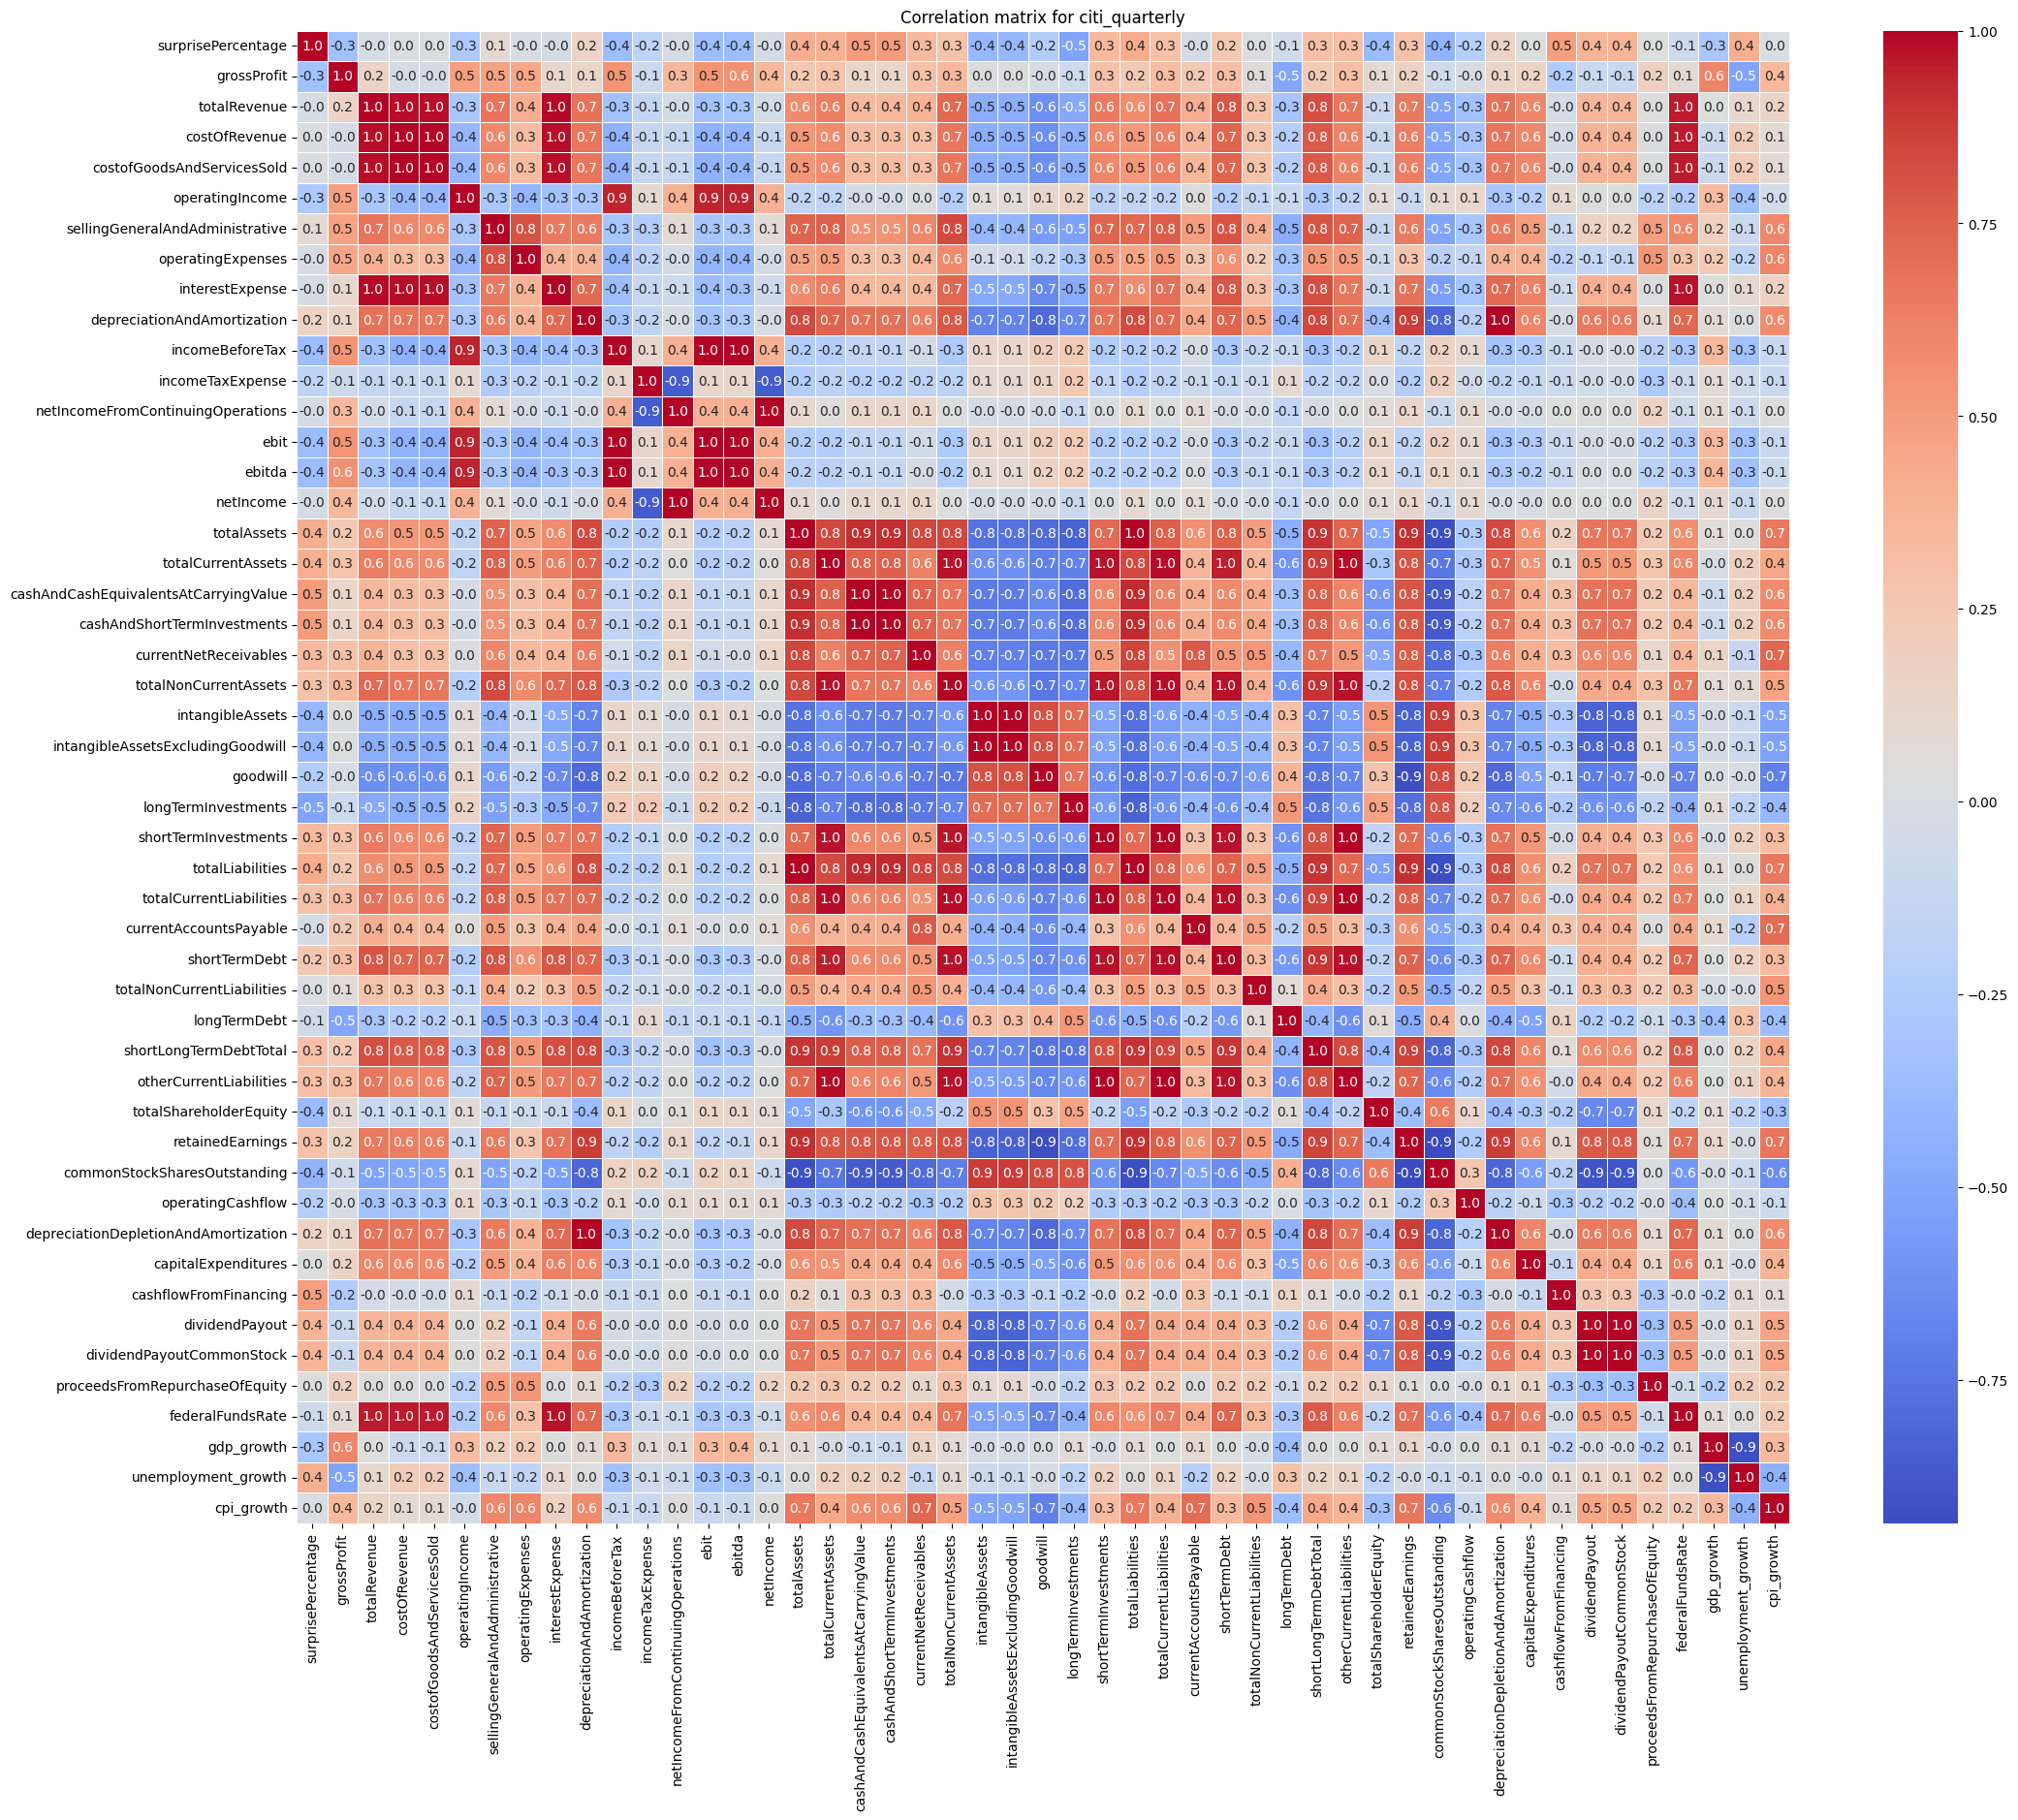

In [ ]:
# Corrplot citi_quarterly

corr = citi_quarterly.corr(numeric_only=True) # Explicitly tell pandas to only use numeric columns

plt.figure(figsize=(25, 20))
sns.heatmap(corr, annot=True, fmt=".1f", cmap='coolwarm', cbar=True, square=True, linewidths=0.5)

plt.title('Correlation matrix for citi_quarterly')
plt.show()

In [ ]:
# 1. Calculate correlations of all numeric columns with 'surprisePercentage'
corr_series = citi_quarterly.corr()['surprisePercentage'].drop('surprisePercentage')

# 2. Sort correlations by absolute value (strongest first)
corr_series_sorted = corr_series.reindex(corr_series.abs().sort_values(ascending=False).index)

# 3. Plot as a horizontal bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=corr_series_sorted.values, y=corr_series_sorted.index, palette='coolwarm')

plt.title('Correlation of features with surprisePercentage - Citi')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')

/tmp/ipython-input-254-2798289278.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_series_sorted.values, y=corr_series_sorted.index, palette='coolwarm')


Text(0, 0.5, 'Features')

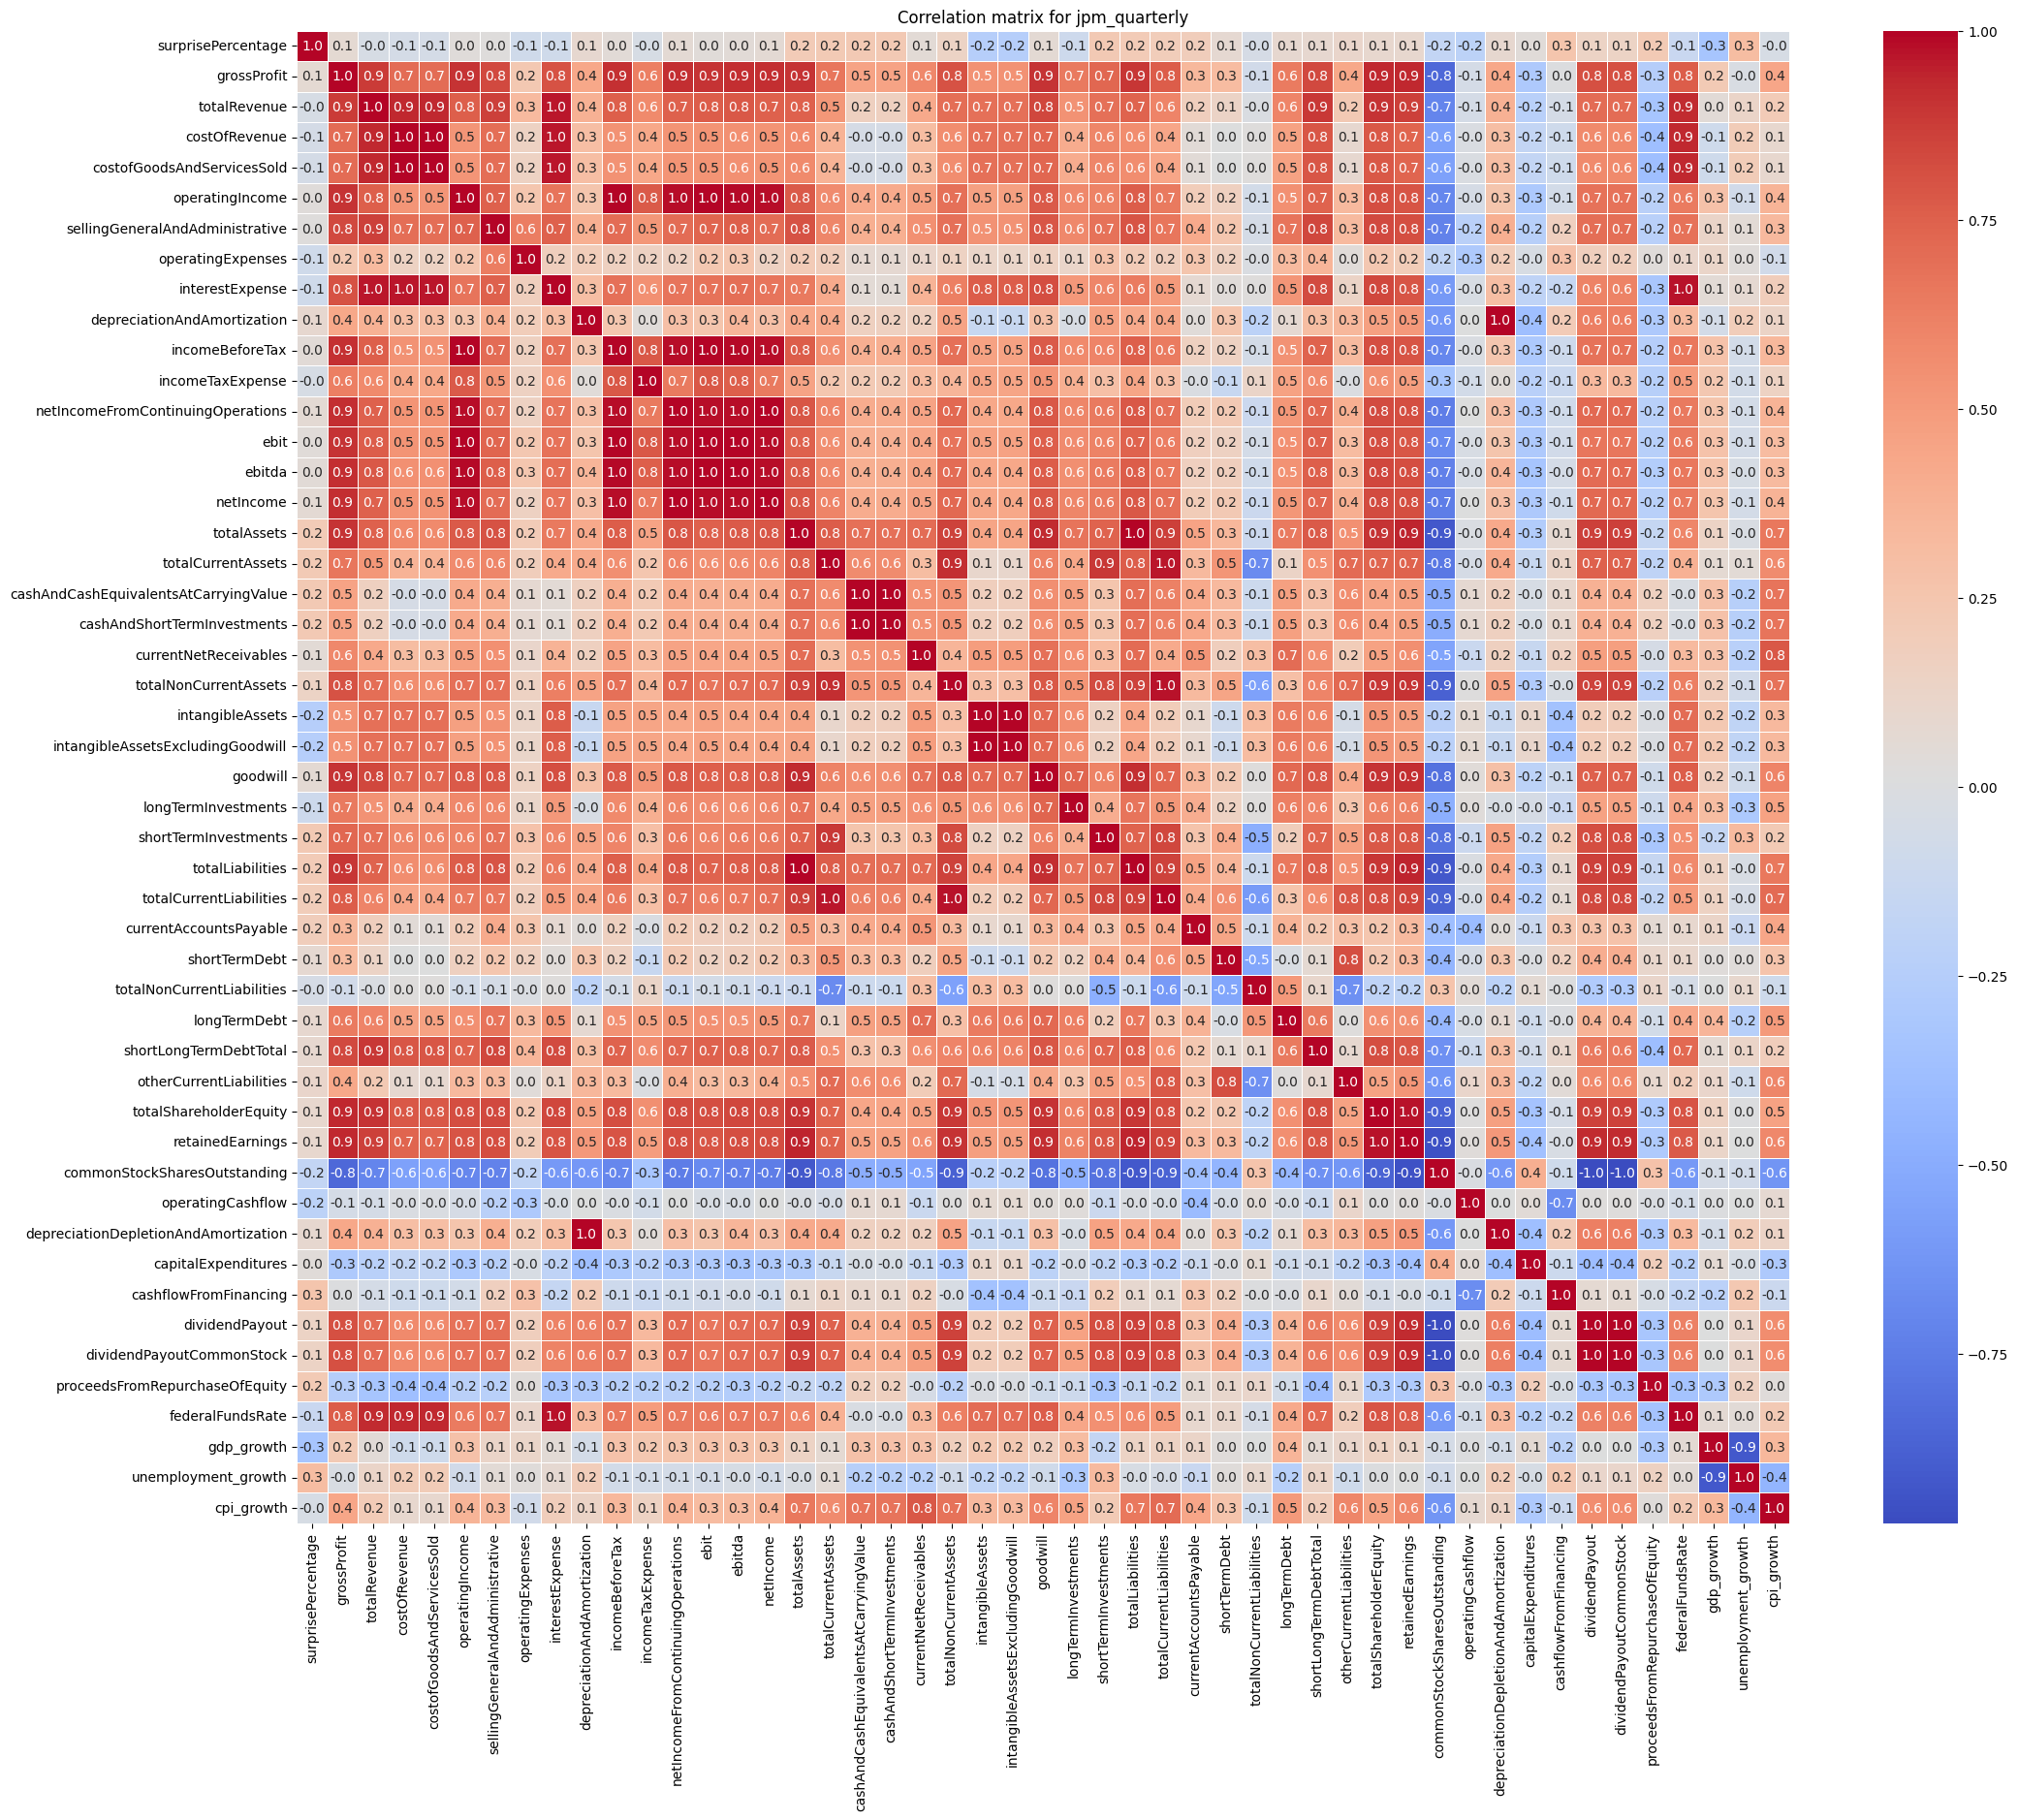

In [ ]:
# Corrplot jpm_quarterly

corr = jpm_quarterly.corr(numeric_only=True) # Explicitly tell pandas to only use numeric columns

plt.figure(figsize=(25, 20))
sns.heatmap(corr, annot=True, fmt=".1f", cmap='coolwarm', cbar=True, square=True, linewidths=0.5)

plt.title('Correlation matrix for jpm_quarterly')
plt.show()

/tmp/ipython-input-256-1629536425.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_series_sorted.values, y=corr_series_sorted.index, palette='coolwarm')


Text(0, 0.5, 'Features')

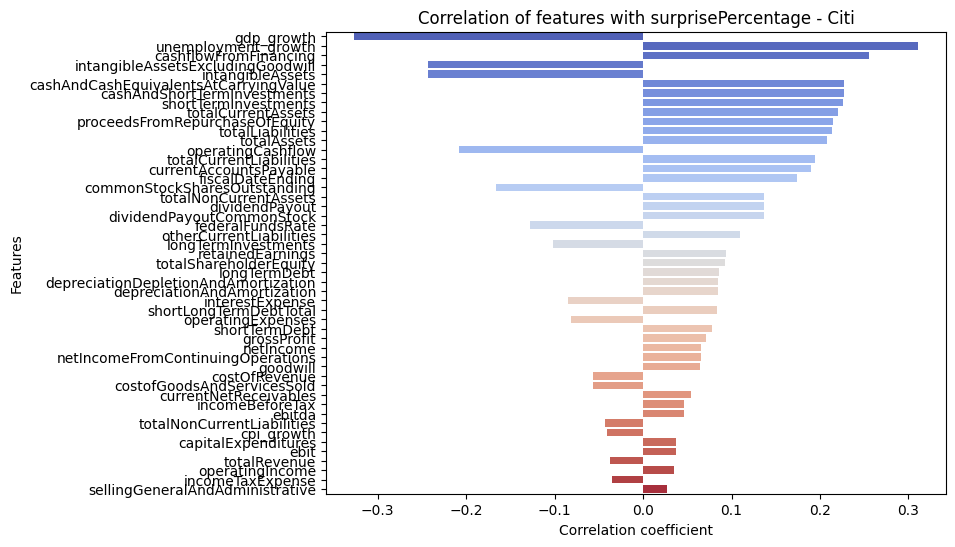

In [ ]:
# 1. Calculate correlations of all numeric columns with 'surprisePercentage'
corr_series = jpm_quarterly.corr()['surprisePercentage'].drop('surprisePercentage')

# 2. Sort correlations by absolute value (strongest first)
corr_series_sorted = corr_series.reindex(corr_series.abs().sort_values(ascending=False).index)

# 3. Plot as a horizontal bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=corr_series_sorted.values, y=corr_series_sorted.index, palette='coolwarm')

plt.title('Correlation of features with surprisePercentage - Citi')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')

## 4) Feature Engineering

In [ ]:
citi_quarterly.tail(10)

fiscalDateEnding  surprisePercentage   grossProfit  totalRevenue  \
35       2016-06-30             12.7273  1.559800e+10  2.049500e+10   
36       2016-03-31              6.7961  1.610600e+10  2.135700e+10   
37       2015-12-31              0.9524  1.704500e+10  2.163300e+10   
38       2015-09-30              2.3438  1.800300e+10  2.252100e+10   
39       2015-06-30              8.2090  1.801800e+10  2.276400e+10   
40       2015-03-31              9.3525  1.660000e+10  2.097100e+10   
41       2014-12-31            -33.3333  1.814400e+10  2.301400e+10   
42       2014-09-30              2.6786  1.787700e+10  2.304000e+10   
43       2014-06-30             18.0952  1.844000e+10  2.379700e+10   
44       2014-03-31             14.0351           NaN           NaN   

    costOfRevenue  costofGoodsAndServicesSold  operatingIncome  \
35   4.897000e+09                4.897000e+09     4.987000e+09   
36   5.251000e+09                5.251000e+09     4.808000e+09   
37   4.588000e+09                4.588000e+09     6.187000e+09   
38   4.518000e+09                4.518000e+09     6.894000e+09   
39   4.746000e+09                4.746000e+09     6.937000e+09   
40   4.371000e+09                4.371000e+09     1.373000e+09   
41   4.870000e+09                4.870000e+09     4.984000e+09   
42   5.163000e+09                5.163000e+09     2.174000e+09   
43   5.357000e+09                5.357000e+09     6.083000e+09   
44   5.510303e+09                5.510303e+09              NaN   

    sellingGeneralAndAdministrative  operatingExpenses  interestExpense  \
35                     5.644000e+09       1.061100e+10     2.940000e+09   
36                     5.609000e+09       1.129800e+10     2.901000e+09   
37                     5.510000e+09       1.085800e+10     2.941000e+09   
38                     5.664000e+09       1.110900e+10     3.051000e+09   
39                     5.717000e+09       1.108100e+10     3.028000e+09   
40                     6.608000e+09       1.522700e+10     3.159000e+09   
41                     6.319000e+09       1.316000e+10     3.325000e+09   
42                     6.210000e+09       1.570300e+10     3.615000e+09   
43                     6.218000e+09       1.235700e+10     3.591000e+09   
44                              NaN                NaN              NaN   

    depreciationAndAmortization  incomeBeforeTax  incomeTaxExpense  \
35                  908000000.0     4.987000e+09      1.479000e+09   
36                  874000000.0     4.808000e+09      1.403000e+09   
37                  865000000.0     6.187000e+09      1.881000e+09   
38                  882000000.0     6.894000e+09      2.036000e+09   
39                  885000000.0     6.937000e+09      2.120000e+09   
40                  916000000.0     1.373000e+09      9.910000e+08   
41                  934000000.0     4.984000e+09      2.068000e+09   
42                  896000000.0     2.174000e+09      1.921000e+09   
43                  843000000.0     6.083000e+09      2.131000e+09   
44                          NaN              NaN               NaN   

    netIncomeFromContinuingOperations          ebit        ebitda  \
35                       3.508000e+09  4.987000e+09  5.895000e+09   
36                       3.405000e+09  4.808000e+09  5.682000e+09   
37                       4.306000e+09  6.187000e+09  7.052000e+09   
38                       4.858000e+09  6.894000e+09  7.776000e+09   
39                       4.817000e+09  6.937000e+09  7.822000e+09   
40                       3.820000e+08  1.373000e+09  2.289000e+09   
41                       2.914000e+09  4.984000e+09  5.918000e+09   
42                       2.530000e+08  2.174000e+09  3.070000e+09   
43                       3.951000e+09  6.083000e+09  6.926000e+09   
44                                NaN           NaN           NaN   

       netIncome   totalAssets  totalCurrentAssets  \
35  3.501000e+09  1.800967e+12        4.941660e+11   
36  3.335000e+09  1.731210e+1

In [ ]:
# Dataframe shape pre feature eng

citi_quarterly.shape

(45, 50)

### 4.1) Lagged EPS Surprise

In [ ]:
# EPS surprise from last quarter

citi_quarterly['surprisePercentage_last_quarter'] = citi_quarterly['surprisePercentage'].shift(-1)
jpm_quarterly['surprisePercentage_last_quarter'] = jpm_quarterly['surprisePercentage'].shift(-1)

### 4.2) Financial Ratios

These were suggested by an LLM

In [ ]:
# Cash ratio

citi_quarterly['cashRatio'] = citi_quarterly['cashAndShortTermInvestments'] / citi_quarterly['totalCurrentLiabilities']
jpm_quarterly['cashRatio'] = jpm_quarterly['cashAndShortTermInvestments'] / jpm_quarterly['totalCurrentLiabilities']

In [ ]:
# Return on Equity (ROE)

citi_quarterly['returnOnEquity'] = citi_quarterly['netIncome'] / citi_quarterly['totalShareholderEquity']
jpm_quarterly['returnOnEquity'] = jpm_quarterly['netIncome'] / jpm_quarterly['totalShareholderEquity']

In [ ]:
# EBITDA margin

citi_quarterly['ebitdamargin'] = citi_quarterly['ebitda'] / citi_quarterly['totalRevenue']
jpm_quarterly['ebitdamargin'] = jpm_quarterly['ebitda'] / jpm_quarterly['totalRevenue']

In [ ]:
# Debt to Equity

citi_quarterly['debtToEquity'] = citi_quarterly['shortLongTermDebtTotal'] / citi_quarterly['totalShareholderEquity']
jpm_quarterly['debtToEquity'] = jpm_quarterly['shortLongTermDebtTotal'] / jpm_quarterly['totalShareholderEquity']

In [ ]:
# Interest Coverage

citi_quarterly['interestCoverage'] = citi_quarterly['ebit'] / citi_quarterly['interestExpense']
jpm_quarterly['interestCoverage'] = jpm_quarterly['ebit'] / jpm_quarterly['interestExpense']

In [ ]:
# Cash Conversion

citi_quarterly['cashConversion'] = citi_quarterly['operatingCashflow'] / citi_quarterly['netIncome']
jpm_quarterly['cashConversion'] = jpm_quarterly['operatingCashflow'] / jpm_quarterly['netIncome']

In [ ]:
# Share Buyback rate

citi_quarterly['shareBuybackRate'] = citi_quarterly['commonStockSharesOutstanding'].diff(-1) / citi_quarterly['commonStockSharesOutstanding']
jpm_quarterly['shareBuybackRate'] = jpm_quarterly['commonStockSharesOutstanding'].diff(-1) / jpm_quarterly['commonStockSharesOutstanding']

In [ ]:
# Dividend Payout ratio

citi_quarterly['dividendPayoutRatio'] = citi_quarterly['dividendPayout'] / citi_quarterly['netIncome']
jpm_quarterly['dividendPayoutRatio'] = jpm_quarterly['dividendPayout'] / jpm_quarterly['netIncome']

In [ ]:
# Liabilities to Assets ratio

citi_quarterly['liabilitiesToAssets'] = citi_quarterly['totalLiabilities'] / citi_quarterly['totalAssets']
jpm_quarterly['liabilitiesToAssets'] = jpm_quarterly['totalLiabilities'] / jpm_quarterly['totalAssets']

### 4.3) Growth rates

In [ ]:
# Net Income growth rate

citi_quarterly['netIncomeGrowthRate'] = citi_quarterly['netIncome'].pct_change(-1)
jpm_quarterly['netIncomeGrowthRate'] = jpm_quarterly['netIncome'].pct_change(-1)

/tmp/ipython-input-270-2414277681.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  citi_quarterly['netIncomeGrowthRate'] = citi_quarterly['netIncome'].pct_change(-1)
/tmp/ipython-input-270-2414277681.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  jpm_quarterly['netIncomeGrowthRate'] = jpm_quarterly['netIncome'].pct_change(-1)


In [ ]:
# Interest expense growth rate

citi_quarterly['interestExpenseGrowthRate'] = citi_quarterly['interestExpense'].pct_change(-1)
jpm_quarterly['interestExpenseGrowthRate'] = jpm_quarterly['interestExpense'].pct_change(-1)

/tmp/ipython-input-271-159785728.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  citi_quarterly['interestExpenseGrowthRate'] = citi_quarterly['interestExpense'].pct_change(-1)
/tmp/ipython-input-271-159785728.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  jpm_quarterly['interestExpenseGrowthRate'] = jpm_quarterly['interestExpense'].pct_change(-1)


In [ ]:
# Fed funds growth rate

citi_quarterly['fedFundsGrowthRate'] = citi_quarterly['federalFundsRate'].pct_change(-1)
jpm_quarterly['fedFundsGrowthRate'] = jpm_quarterly['federalFundsRate'].pct_change(-1)

/tmp/ipython-input-272-3080962362.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  citi_quarterly['fedFundsGrowthRate'] = citi_quarterly['federalFundsRate'].pct_change(-1)
/tmp/ipython-input-272-3080962362.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  jpm_quarterly['fedFundsGrowthRate'] = jpm_quarterly['federalFundsRate'].pct_change(-1)


In [ ]:
# Dataframe shape post feature eng

citi_quarterly.shape

(45, 63)

## 5) Join NLP features to dataset

In [ ]:
# Load NLP features from CSV
# NOTE THE SOURCE DATA IS IN A SEPARATE NOTEBOOK

jpm_q_nlp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/jpm_qa(per year & quarter).csv')
citi_q_nlp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/citi_qa(per year & quarter).csv')

In [ ]:
# Check data head

jpm_q_nlp.head(5)

year  quarter  Answer_sentiment  Answer_avg_word_length  \
0  2015        1          0.121675                4.496974   
1  2015        2          0.277695                4.519989   
2  2015        3          0.381524                4.215252   
3  2015        4          0.270139                4.603873   
4  2016        1          0.356109                4.549392   

   Answer_avg_sentence_length  vagueness_count  vagueness_rate  jargon_count  \
0                   24.606548         0.964286        0.008106      1.142857   
1                   20.484451         1.189189        0.006841      1.405405   
2                   15.265726         0.742857        0.005533      1.000000   
3                   14.676992         0.971429        0.008779      1.971429   
4                   14.980693         0.676471        0.006748      0.852941   

   jargon_rate  flesch_reading_ease  gunning_fog  smog_index  coleman_liau  \
0     0.009409            57.631299    14.217627   12.587378      7.264564   
1     0.010481            58.183925    12.096984   10.612546      5.815114   
2     0.007166            64.339316     9.747810    9.313523      4.714985   
3     0.011178            62.760786    10.785840   10.080883      5.371665   
4     0.008167            61.886238    10.278162    9.887067      6.548599   

   automated_readability  
0              12.054616  
1              10.983362  
2               7.924227  
3               8.149681  
4               8.934356

In [ ]:
# Create fiscal date ending column for quarter

jpm_q_nlp['fiscalDateEnding'] = pd.to_datetime(
    jpm_q_nlp['year'].astype(str) + 'Q' + jpm_q_nlp['quarter'].astype(str)
).dt.to_period('Q').dt.end_time.dt.date

citi_q_nlp['fiscalDateEnding'] = pd.to_datetime(
    citi_q_nlp['year'].astype(str) + 'Q' + citi_q_nlp['quarter'].astype(str)
).dt.to_period('Q').dt.end_time.dt.date


/tmp/ipython-input-276-90777377.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  jpm_q_nlp['fiscalDateEnding'] = pd.to_datetime(
/tmp/ipython-input-276-90777377.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  citi_q_nlp['fiscalDateEnding'] = pd.to_datetime(


In [ ]:
# Lag the nlp data

jpm_q_nlp_lagged = lag_fiscal_end_date(jpm_q_nlp)
citi_q_nlp_lagged = lag_fiscal_end_date(citi_q_nlp)

In [ ]:
# Drop irrelevant year and quarter data
jpm_q_nlp_lagged = jpm_q_nlp_lagged.drop(columns=['year', 'quarter'])
citi_q_nlp_lagged = citi_q_nlp_lagged.drop(columns=['year', 'quarter'])

In [ ]:
# List of nlp features and remove fiscalDateEnding
nlp_features = jpm_q_nlp_lagged.columns.tolist()
nlp_features.remove('fiscalDateEnding')
nlp_features

['Answer_sentiment',
 'Answer_avg_word_length',
 'Answer_avg_sentence_length',
 'vagueness_count',
 'vagueness_rate',
 'jargon_count',
 'jargon_rate',
 'flesch_reading_ease',
 'gunning_fog',
 'smog_index',
 'coleman_liau',
 'automated_readability']

In [ ]:
# Align dtypes for fiscal date ending

jpm_quarterly['fiscalDateEnding'] = pd.to_datetime(jpm_quarterly['fiscalDateEnding'])
jpm_q_nlp_lagged['fiscalDateEnding'] = pd.to_datetime(jpm_q_nlp_lagged['fiscalDateEnding'])

citi_quarterly['fiscalDateEnding'] = pd.to_datetime(citi_quarterly['fiscalDateEnding'])
citi_q_nlp_lagged['fiscalDateEnding'] = pd.to_datetime(citi_q_nlp_lagged['fiscalDateEnding'])

In [ ]:
# Join nlp_lagged data to the quarterly datasets
jpm_quarterly = jpm_quarterly.merge(jpm_q_nlp_lagged, on='fiscalDateEnding', how='left')
citi_quarterly = citi_quarterly.merge(citi_q_nlp_lagged, on='fiscalDateEnding', how='left')

In [ ]:
# Check data head
jpm_quarterly.head(10)

fiscalDateEnding  surprisePercentage   grossProfit  totalRevenue  \
0       2025-03-31              6.5076  4.013700e+10  6.700700e+10   
1       2024-12-31             17.0316  3.954300e+10  6.966700e+10   
2       2024-09-30              8.9776  3.903900e+10  6.783500e+10   
3       2024-06-30              1.6706  4.005000e+10  6.626400e+10   
4       2024-03-31              8.0292  3.584900e+10  6.193300e+10   
5       2023-12-31             -8.4337  3.839000e+10  6.159100e+10   
6       2023-09-30              9.3434  3.569600e+10  5.844700e+10   
7       2023-06-30             18.7500  3.607400e+10  5.464100e+10   
8       2023-03-31             20.2346  3.225900e+10  3.454700e+10   
9       2022-12-31             15.9609  2.918800e+10  3.271600e+10   

   costOfRevenue  costofGoodsAndServicesSold  operatingIncome  \
0   2.687000e+10                2.687000e+10     1.737500e+10   
1   3.012400e+10                3.012400e+10     1.697800e+10   
2   2.879600e+10                2.879600e+10     2.343500e+10   
3   2.621400e+10                2.621400e+10     1.729300e+10   
4   2.608400e+10                2.608400e+10     1.132600e+10   
5   2.320100e+10                2.320100e+10     1.673300e+10   
6   2.275100e+10                2.275100e+10     1.758600e+10   
7   1.856700e+10                1.856700e+10     1.596700e+10   
8   1.511500e+10                1.511500e+10     1.115500e+10   
9   3.528000e+09                3.528000e+09     1.361400e+10   

   sellingGeneralAndAdministrative  operatingExpenses  interestExpense  \
0                     1.246900e+10       2.276200e+10     2.421600e+10   
1                     1.281700e+10       2.256500e+10     2.701100e+10   
2                     1.295300e+10       1.560400e+10     2.576700e+10   
3                     1.336600e+10       2.275700e+10     2.435600e+10   
4                     1.184700e+10       1.936800e+10     2.333300e+10   
5                     1.172600e+10       1.905500e+10     2.183000e+10   
6                     1.121600e+10       1.811000e+10     1.986500e+10   
7                     1.199300e+10       2.010700e+10     1.629300e+10   
8                     4.908000e+09      -1.902200e+10     1.286200e+10   
9                     1.053900e+10       1.917800e+10     8.093000e+09   

   depreciationAndAmortization  incomeBeforeTax  incomeTaxExpense  \
0                 1.965000e+09     1.737500e+10      3.370000e+09   
1                 1.967000e+09     1.697800e+10      4.080000e+09   
2                 2.002000e+09     2.343500e+10      5.286000e+09   
3                 2.004000e+09     1.729300e+10      3.874000e+09   
4                 3.337000e+09     1.132600e+10      2.019000e+09   
5                 2.019000e+09     1.673300e+10      3.582000e+09   
6                 5.070000e+08     1.758600e+10      3.114000e+09   
7                 1.649000e+09     1.596700e+10      3.345000e+09   
8                 1.671000e+09     1.323700e+10      2.229000e+09   
9                 1.771000e+09     1.200100e+10      2.264000e+09   

   netIncomeFromContinuingOperations          ebit        ebitda  \
0                       1.400500e+10  1.737500e+10  1.934000e+10   
1                       1.289800e+10  1.697800e+10  1.894500e+10   
2                       1.814900e+10  2.343500e+10  2.543700e+10   
3                       1.341900e+10  1.729300e+10  1.929700e+10   
4                       9.307000e+09  1.132600e+10  1.466300e+10   
5                       1.315100e+10  1.673300e+10  1.875200e+10   
6                       1.447200e+10  1.758600e+10  1.809300e+10   
7                       1.262200e+10  1.596700e+10  1.761600e+10   
8                       1.100800e+10  1.115500e+10  1.282600e+10   
9                       9.737000e+09  1.200100e+10  1.377200e+10   

      netIncome   totalAssets  totalCurrentAssets  \
0  1.400500e+10  4.002814e+12        1.763945e+12   
1  1.289800e+10  4.210048e+12        1.895172e+12   
2  1.814900e+10  4.143003e+12   

## 6) Merge Datasets across banks

### 6.1) Merge dataset

In [ ]:
# Combine datasets and create dummy for bank name

# Add a dummy column 'is_citi' to each DataFrame
citi_quarterly['is_citi'] = 1
jpm_quarterly['is_citi'] = 0

# Concatenate vertically (union)
combined_df = pd.concat([citi_quarterly, jpm_quarterly], ignore_index=True)

In [ ]:
# Drop rows of data where the fiscal date ending is prior to 2015-03-01

combined_df = combined_df[combined_df['fiscalDateEnding'] >= '2015-03-01']

In [ ]:
# Drop fiscal date column

combined_df = combined_df.drop(columns=['fiscalDateEnding'])

In [ ]:
# Create a binary variable column if surprisepercentage is < 0

combined_df['is_neg_surprise'] = np.where(combined_df['surprisePercentage'] < 0, 1, 0)

In [ ]:
# Count of neg_surprise

combined_df['is_neg_surprise'].value_counts()

is_neg_surprise
0    76
1     6
Name: count, dtype: int64

Very low n of neg surprise so creating an adjusted measure

In [ ]:
# Create a binary variable column if surprisepercentage is < 5

combined_df['is_neg_surprise_adj'] = np.where(combined_df['surprisePercentage'] < 5, 1, 0)

In [ ]:
# Count of neg_surprise

combined_df['is_neg_surprise_adj'].value_counts()

is_neg_surprise_adj
0    57
1    25
Name: count, dtype: int64

In [ ]:
# Check shape

combined_df.shape

(82, 77)

In [ ]:
# Check head

combined_df.head(10)

surprisePercentage   grossProfit  totalRevenue  costOfRevenue  \
0              5.9459  1.700500e+10  4.090000e+10   2.389500e+10   
1              9.8361  1.766800e+10  4.335900e+10   2.569100e+10   
2             15.2672  1.768100e+10  4.263800e+10   2.495700e+10   
3              9.3525  1.867800e+10  4.372200e+10   2.504400e+10   
4             51.2195  1.531700e+10  4.139500e+10   2.607800e+10   
5              3.7037  1.792100e+10  4.074800e+10   2.282700e+10   
6             25.6198  1.762600e+10  3.818700e+10   2.056100e+10   
7              5.3846  1.843700e+10  3.645200e+10   1.801500e+10   
8             11.3772  1.618100e+10  3.043900e+10   1.425800e+10   
9             -3.5088  1.655400e+10  2.524000e+10   8.686000e+09   

   costofGoodsAndServicesSold  operatingIncome  \
0                2.389500e+10     4.842000e+09   
1                2.569100e+10     4.390000e+09   
2                2.495700e+10     4.310000e+09   
3                2.504400e+10     4.544000e+09   
4                2.607800e+10    -2.103000e+09   
5                2.282700e+10     4.788000e+09   
6                2.056100e+10     4.042000e+09   
7                1.801500e+10     6.183000e+09   
8                1.425800e+10     6.227000e+09   
9                8.686000e+09     4.394000e+09   

   sellingGeneralAndAdministrative  operatingExpenses  interestExpense  \
0                     6.940000e+09       1.218100e+10     2.131400e+10   
1                     7.086000e+09       1.327800e+10     2.309400e+10   
2                     6.906000e+09       1.337100e+10     2.249400e+10   
3                     7.700000e+09       1.413400e+10     2.271600e+10   
4                     6.906000e+09       1.244600e+10     2.255500e+10   
5                     7.449000e+09       1.313300e+10     2.100900e+10   
6                     7.402000e+09       1.358400e+10     1.874700e+10   
7                     7.562000e+09       1.225400e+10     1.604700e+10   
8                     6.638000e+09       1.300500e+10     1.243800e+10   
9                     6.770000e+09       1.216000e+10     7.356000e+09   

   depreciationAndAmortization  incomeBeforeTax  incomeTaxExpense  \
0                 1.019000e+09     3.802000e+09      9.120000e+08   
1                 1.081000e+09     4.390000e+09      1.116000e+09   
2                 1.101000e+09     4.310000e+09      1.047000e+09   
3                 1.110000e+09     4.544000e+09      1.136000e+09   
4                 1.172000e+09    -2.103000e+09     -2.960000e+08   
5                 1.141000e+09     4.788000e+09      1.203000e+09   
6                 1.136000e+09     4.042000e+09      1.090000e+09   
7                 1.111000e+09     6.183000e+09      1.531000e+09   
8                 1.108000e+09     3.176000e+09      6.400000e+08   
9                 1.065000e+09     4.394000e+09      8.790000e+08   

   netIncomeFromContinuingOperations          ebit        ebitda  \
0                       2.890000e+09  3.802000e+09  4.821000e+09   
1                       3.274000e+09  4.390000e+09  5.471000e+09   
2                       3.263000e+09  4.310000e+09  5.411000e+09   
3                       3.408000e+09  4.544000e+09  5.654000e+09   
4                      -1.807000e+09 -2.103000e+09 -9.310000e+08   
5                       3.585000e+09  4.788000e+09  5.929000e+09   
6                       2.952000e+09  4.042000e+09  5.178000e+09   
7                       4.652000e+09  6.183000e+09  7.294000e+09   
8                       2.536000e+09  3.176000e+09  4.284000e+09   
9                       3.515000e+09  4.394000e+09  5.459000e+09   

      netIncome   totalAssets  totalCurrentAssets  \
0  2.856000e+09  2.352945e+12        1.072653e+12   
1  3.238000e+09  2.430663e+12        1.127142e+12   
2  3.217000e+09  2.405686e+12        1.111402e+12   
3  3.371000e+09  2.432510e+12        1.134433e+12   
4 -1.839000e+09  2.411834e+12        1.120490e+12   
5  3.546000e+09  2.368477e+12        1.108994e+12   
6  2.915

### 6.2) Create a dataset with NLP features

In [ ]:
# Create a copy of dataset with NLP

combined_df_nlp = combined_df.copy()
combined_df = combined_df.drop(columns=nlp_features)

In [ ]:
# Save both datasets

combined_df_nlp.to_csv('/content/drive/MyDrive/Colab Notebooks/combined_df_nlp.csv', index=False)
combined_df.to_csv('/content/drive/MyDrive/Colab Notebooks/combined_df.csv', index=False)

In [ ]:
# Load both datasets

combined_df_nlp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/combined_df_nlp.csv')
combined_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/combined_df.csv')

## 7) Model: Prediction of negative EPS surprise

### 7.0) Split dataset

In [ ]:
# Split dataset

X = combined_df.drop(columns=['surprisePercentage', 'is_neg_surprise', 'is_neg_surprise_adj'])
y = combined_df['is_neg_surprise']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
# Check data shape

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(45, 62) (12, 62) (25, 62)
(45,) (12,) (25,)


In [ ]:
print(f"We have {X.shape[1]} features")

We have 62 features


### 7.1) Naive Prediction Baseline

***We need a baseline to evaluate our models against. The naive prediction uses last period as the prediction for the current period***

In [ ]:
# Create a copy of the dataframe with lagged neg surprise

df = combined_df.copy()

df['lagged_is_neg_surprise'] = df['is_neg_surprise'].shift(-1)

# When the dataframe switches from citi to jpm, default the lagged surprise to 0

df.loc[df['is_citi'] != df['is_neg_surprise'].shift(-1), 'lagged_is_neg_surprise'] = 0

In [ ]:
# Filter df just to the indices for y_test

df_filtered = df.loc[y_test.index]

In [ ]:
# Create y_test and y_pred

y_test = df_filtered['is_neg_surprise']
y_pred = df_filtered['lagged_is_neg_surprise']

In [ ]:
# Evaluate performance of naive forecast

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Naive Prediction Baseline Evaluation")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Naive Prediction Baseline Evaluation
Accuracy: 0.92
Precision: 0.00
Recall: 0.00


***The naive baseline is poor, meaning that last period's EPS surprise does not give much information on the current period EPS surprise***

### 7.2) Random Forest Model

In [ ]:
# Fit random forest classifier
random_forest = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42, class_weight='balanced')

rf = random_forest.fit(X_train, y_train)

In [ ]:
# Show confusion matrix and precision and recall values

sns.heatmap(confusion_matrix(y_test, rf.predict(X_test)), annot=True, fmt='d')
plt.title("Confusion Matrix - RF")

print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        23
           1       0.00      0.00      0.00         2

    accuracy                           0.92        25
   macro avg       0.46      0.50      0.48        25
weighted avg       0.85      0.92      0.88        25



***As the dataset is very imbalanced, even after balancing using weights, the RF model still predicts all observations as 0***

### 7.3) Random Forest Model - Tuned

In [ ]:
# Hyperparameter distributions for random search

param_distributions = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

In [ ]:
# Set up random search

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='recall',              # Set to recall as we want to catch the EPS misses .
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1                      # use all processors
)

# Fit to data
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d3c3b6abed0>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d3c3bd68510>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d3c3bd69290>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d3c3a12bd90>},
                   random_state=42, scoring='recall', verbose=1)

In [ ]:
# Best model and parameters
best_rf = random_search.best_estimator_
print("Best parameters found:", random_search.best_params_)

Best parameters found: {'bootstrap': True, 'max_depth': 33, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 171}


In [ ]:
# Predict using the best model
y_pred = best_rf.predict(X_test)

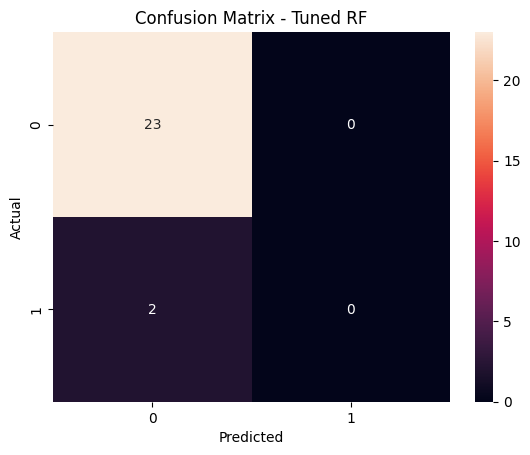

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        23
           1       0.00      0.00      0.00         2

    accuracy                           0.92        25
   macro avg       0.46      0.50      0.48        25
weighted avg       0.85      0.92      0.88        25



In [ ]:
# Confusion Matrix for best RF model

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Confusion Matrix - Tuned RF")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_test, y_pred))

***Tuning hyperparameters does not help - the issue is the class imbalance***

## 8) Model Prediction of <5% EPS surprise

***We have changed the threshold of "negative" EPS surprise to <5% to address the class imbalance problem***

### 8.0) Split dataset

In [ ]:
# Split dataset

X = combined_df.drop(columns=['surprisePercentage', 'is_neg_surprise', 'is_neg_surprise_adj'])
y = combined_df['is_neg_surprise_adj']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

### 8.1) Naive Prediction Baseline

In [ ]:
# Create a copy of the dataframe with lagged neg surprise

df = combined_df.copy()

df['lagged_is_neg_surprise_adj'] = df['is_neg_surprise_adj'].shift(-1)

# When the dataframe switches from citi to jpm, default the lagged surprise to 0

df.loc[df['is_citi'] != df['is_neg_surprise_adj'].shift(-1), 'lagged_is_neg_surprise_adj'] = 0

In [ ]:
# Filter df just to the indices for y_test

df_filtered = df.loc[y_test.index]

In [ ]:
y_test = df_filtered['is_neg_surprise_adj']
y_pred = df_filtered['lagged_is_neg_surprise_adj']

In [ ]:
# Evaluate performance of naive forecast

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Naive Prediction Baseline Evaluation")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Naive Prediction Baseline Evaluation
Accuracy: 0.68
Precision: 0.50
Recall: 0.12


### 8.2) Random Forest Model

In [ ]:
# Fit random forest classifier
random_forest = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42, class_weight='balanced')

rf = random_forest.fit(X_train, y_train)

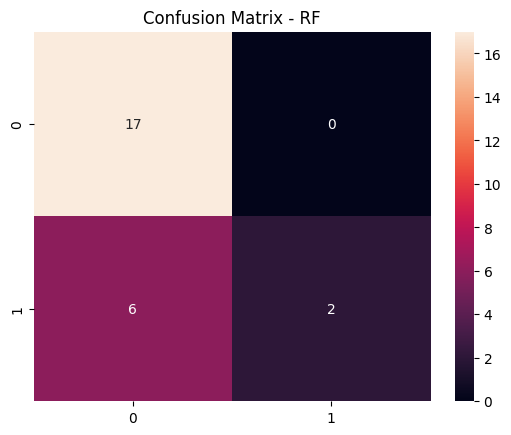

              precision    recall  f1-score   support

           0       0.74      1.00      0.85        17
           1       1.00      0.25      0.40         8

    accuracy                           0.76        25
   macro avg       0.87      0.62      0.62        25
weighted avg       0.82      0.76      0.71        25



In [ ]:
# Show confusion matrix and precision and recall values

sns.heatmap(confusion_matrix(y_test, rf.predict(X_test)), annot=True, fmt='d')
plt.title("Confusion Matrix - RF")
plt.show()

print(classification_report(y_test, rf.predict(X_test)))

***100% precision but low recall - try tuning hyperparameters to maximise recall***

### 8.3) Random Forest Model - Tuned

In [ ]:
# Hyperparameter distributions for random search

param_distributions = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

In [ ]:
# Set up random search

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='recall',              # Set to recall as we want to catch the EPS misses .
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1                      # use all processors
)

# Fit to data
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d3c3bd74f50>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d3c3acd9c50>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d3c39b482d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d3c3a7a5890>},
                   random_state=42, scoring='recall', verbose=1)

In [ ]:
# Best model and parameters
best_rf = random_search.best_estimator_
print("Best parameters found:", random_search.best_params_)

Best parameters found: {'bootstrap': False, 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 101}


In [ ]:
# Predict using the best model
y_pred = best_rf.predict(X_test)

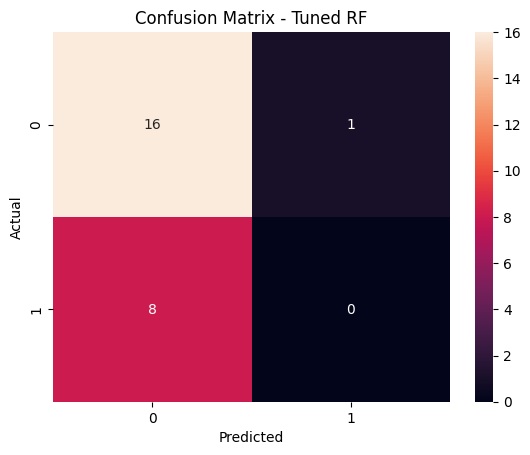

              precision    recall  f1-score   support

           0       0.67      0.94      0.78        17
           1       0.00      0.00      0.00         8

    accuracy                           0.64        25
   macro avg       0.33      0.47      0.39        25
weighted avg       0.45      0.64      0.53        25



In [ ]:
# Confusion Matrix for best RF model

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Confusion Matrix - Tuned RF")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_test, y_pred))

***This tuned model performs worse (though these are very small sample sizes especially in the folds used for hyperparameter optimisation - this makes optimisation very challenging)***

### 8.4) XGBoost Model

In [ ]:
# Initialise XGB model

xgb_clf = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    verbose=0
)

In [ ]:
# Fit XGB Model

xgb_clf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:13:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Show confusion matrix for XGBoost

sns.heatmap(confusion_matrix(y_test, xgb_clf.predict(X_test)), annot=True, fmt='d')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_test, xgb_clf.predict(X_test)))


              precision    recall  f1-score   support

           0       0.75      0.88      0.81        17
           1       0.60      0.38      0.46         8

    accuracy                           0.72        25
   macro avg       0.68      0.63      0.64        25
weighted avg       0.70      0.72      0.70        25



***XGBoost is more promising than the Random Forest Model with hgiher recall and precision***

### 8.5) XGBoost Model - Tuned

In [ ]:
# Initialise XGB

xgb_clf = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    verbosity=0
)

In [ ]:
# Class weight ratio

class_weight_ratio = (y_train == 0).sum() /  (y_train == 1).sum()
class_weight_ratio

np.float64(2.75)

In [ ]:
# Parameter grid for searching
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, class_weight_ratio, 2*class_weight_ratio]  # to handle the obvious class imbalance we have, also seeing if overweighting the positive class helps
}

In [ ]:
# Random search across param grid

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=20,  # number of parameter combinations to try
    scoring='recall',  # focusing on improving recall score - ideally we want to identify real misses/be cautious of potential negative earnings surprises
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 300],
                                        'scale_pos_weight': [1,
                                                             np.float64(2.75),
                                                             np.float64(5.5)],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='recall', verbose=1)

In [ ]:
# Best model and parameters
best_xgb = random_search.best_estimator_
print("Best parameters found:", random_search.best_params_)

Best parameters found: {'subsample': 0.6, 'scale_pos_weight': np.float64(5.5), 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.6}


In [ ]:
# Use the best XGB Model to predict
y_pred = best_xgb.predict(X_test)

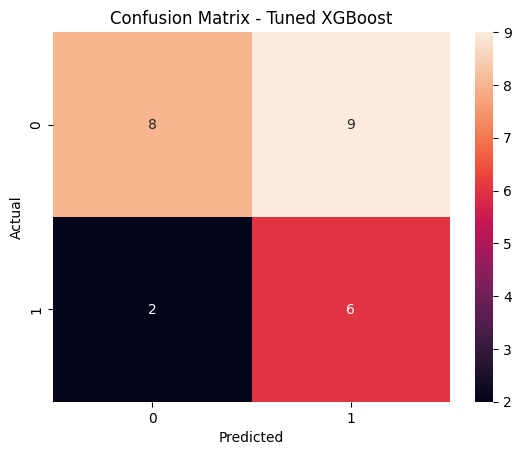

              precision    recall  f1-score   support

           0       0.80      0.47      0.59        17
           1       0.40      0.75      0.52         8

    accuracy                           0.56        25
   macro avg       0.60      0.61      0.56        25
weighted avg       0.67      0.56      0.57        25



In [ ]:
# Confusion matrix for the best XGB Model
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Confusion Matrix - Tuned XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_test, y_pred))

***Tuning has improved both precision and recall***

In [ ]:
# Visualise feature importance for best XGB model

ax = xgb.plot_importance(
    best_xgb.get_booster(),
    importance_type='gain',
    max_num_features=25,
    title=None
)

# Remove the default labels by redrawing blank annotations
for txt in ax.texts:
    txt.set_text('')  # clears the label text

plt.show()

### 8.6) XGBoost Model - Tuned with fewer features

***Whilst XGBoost should be robust to having many features, as our dataset is small, we will experiment with having fewer features which may help to stop overfitting***

In [ ]:
# Top 20 features from XGBoost model with all features

importance_dict = best_xgb.get_booster().get_score(importance_type='gain')

# Convert to DataFrame
importance_df = pd.DataFrame(
    importance_dict.items(),
    columns=['feature', 'importance']
)

# Sort by importance (descending)
importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

# Top 20 features
importance_df[0:20]

feature  importance
0             totalCurrentLiabilities   15.077394
1                 longTermInvestments   11.185966
2              shortLongTermDebtTotal   10.296828
3                 liabilitiesToAssets   10.076506
4   intangibleAssetsExcludingGoodwill    9.674601
5                          gdp_growth    9.645435
6                    intangibleAssets    8.637748
7                    shareBuybackRate    8.274263
8                        ebitdamargin    8.266495
9      proceedsFromRepurchaseOfEquity    8.206533
10            otherCurrentLiabilities    7.859473
11                    incomeBeforeTax    7.771455
12    surprisePercentage_last_quarter    7.689073
13       commonStockSharesOutstanding    7.635583
14                     cashConversion    7.538710
15                     returnOnEquity    7.252661
16                    interestExpense    7.116742
17              totalNonCurrentAssets    7.094139
18  netIncomeFromContinuingOperations    6.872295
19                   interestCoverage    6.856346

In [ ]:
# Create copy of x_train with a smaller set of features

smaller_feature_list = importance_df[0:15]['feature'].tolist()

X_train_smaller = X_train[smaller_feature_list]
X_test_smaller = X_test[smaller_feature_list]

In [ ]:
# Random search across param grid

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=20,  # number of parameter combinations to try
    scoring='recall',  # focusing on improving recall score - ideally we want to identify real misses/be cautious of potential negative earnings surprises
    cv=5,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_smaller, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 300],
                                        'scale_pos_weight': [1,
                                                             np.float64(2.75),
                                                             np.float64(5.5)],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='recall')

In [ ]:
# Best model and parameters
best_xgb = random_search.best_estimator_
print("Best parameters found:", random_search.best_params_)

Best parameters found: {'subsample': 0.6, 'scale_pos_weight': np.float64(5.5), 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.6}


In [ ]:
# Use the best XGB Model to predict
y_pred = best_xgb.predict(X_test_smaller)

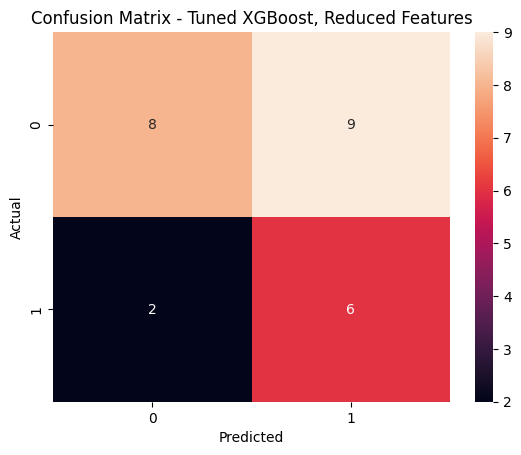

              precision    recall  f1-score   support

           0       0.80      0.47      0.59        17
           1       0.40      0.75      0.52         8

    accuracy                           0.56        25
   macro avg       0.60      0.61      0.56        25
weighted avg       0.67      0.56      0.57        25



In [ ]:
# Confusion matrix for the best XGB Model
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Confusion Matrix - Tuned XGBoost, Reduced Features")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_test, y_pred))

***Model with fewer features did not improve the model precision or recall but we will keep this as the best model version as it is less likely to overfit given it has fewer features***

#### 8.6.1) Cross Validation

In [ ]:
# Cross validation - Recall

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_xgb, X_train, y_train, cv=cv, scoring='recall')

print("CV Recall scores:", scores)
print("Mean Recall score:", np.mean(scores))
print("Recall std dev:", np.std(scores))

CV Recall scores: [0.66666667 0.33333333 0.5        1.         1.        ]
Mean Recall score: 0.7
Recall std dev: 0.26666666666666666


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_xgb, X_train, y_train, cv=cv, scoring='precision')

print("CV Precision scores:", scores)
print("Mean Precision score:", np.mean(scores))
print("Precision std dev:", np.std(scores))

CV Precision scores: [0.66666667 0.33333333 0.25       0.28571429 0.25      ]
Mean Precision score: 0.3571428571428571
Precision std dev: 0.15775494069978518


***Cross validation shows that there is quite a lot of variance in precision and recall across folds, which is unsurprising given the small sample size***

#### 8.6.2) SHAP Plots

In [ ]:
shap.initjs()

# Get SHAP values
shap_ex = shap.TreeExplainer(best_xgb)
vals = shap_ex(X_test_smaller)

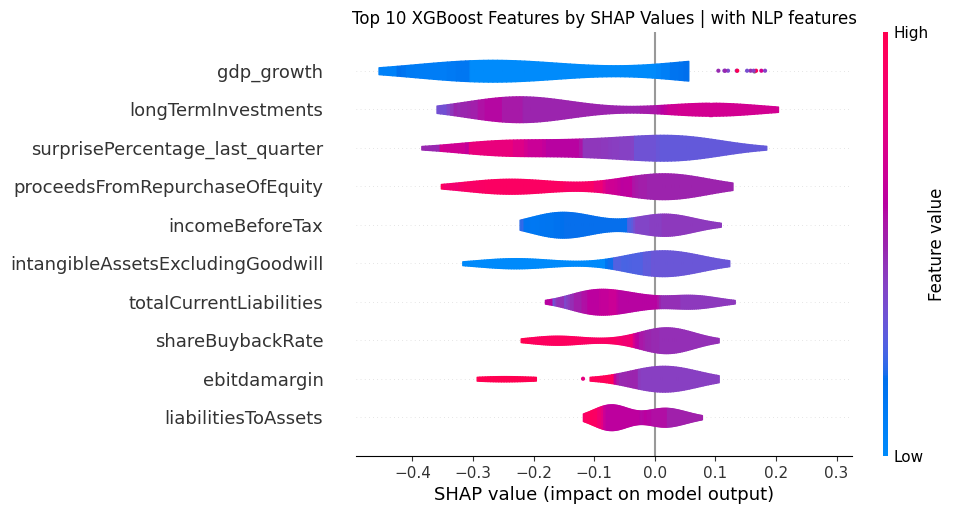

In [ ]:
# Violin plot of features

# Calculate mean absolute SHAP values per feature
mean_abs_shap = vals.abs.mean(0).values

# Get indices of top 10 features by mean absolute SHAP value
top10_idx = np.argsort(mean_abs_shap)[::-1][:10]

# Subset vals to top 10 features (this keeps the shape samples x 10)
top10_vals = shap.Explanation(
    values=vals.values[:, top10_idx],
    base_values=vals.base_values,
    data=vals.data[:, top10_idx],
    feature_names=[vals.feature_names[i] for i in top10_idx]
)

# Plot violin plot for the top 10 features
plt.title('Top 10 XGBoost Features by SHAP Values | with NLP features')
shap.plots.violin(top10_vals)
plt.show()

* Higher GDP growth tends to reduce the likelihood of negative EPS surprise, as growth drives bank profits
* Long term investments increases the likelihood of negative EPS surprise - this is perhaps because struggling banks try to improve their longer term trajectory by making investments
* High share buybacks decreases the likelihood of negative EPS surprise - banks would be unlikely to do this if they were in a poor financial situation and the reduction of shares leads to higher EPS in future periods

## 9) Model: Prediction of negative EPS surprise using NLP features

### 9.0) Split dataset

In [ ]:
# Split dataset

X = combined_df_nlp.drop(columns=['surprisePercentage', 'is_neg_surprise', 'is_neg_surprise_adj'])
y = combined_df_nlp['is_neg_surprise']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(45, 74) (12, 74) (25, 74)
(45,) (12,) (25,)


In [ ]:
print(f"We have {X.shape[1]} features")

We have 74 features


### 9.1) Random Forest Model

In [ ]:
# Fit random forest classifier
random_forest = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42, class_weight='balanced')

rf = random_forest.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        23
           1       0.00      0.00      0.00         2

    accuracy                           0.92        25
   macro avg       0.46      0.50      0.48        25
weighted avg       0.85      0.92      0.88        25



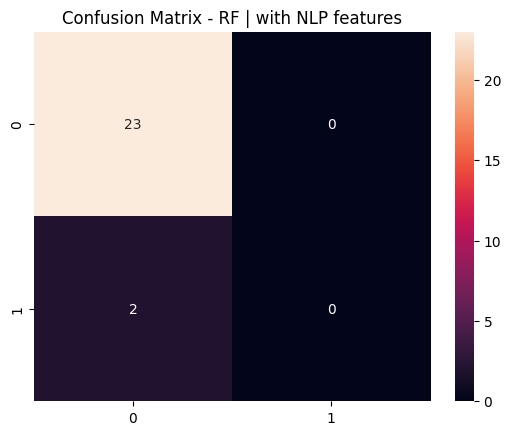

In [ ]:
# Show confusion matrix and precision and recall values

sns.heatmap(confusion_matrix(y_test, rf.predict(X_test)), annot=True, fmt='d')
plt.title("Confusion Matrix - RF | with NLP features")

print(classification_report(y_test, rf.predict(X_test)))

***Unsurprisingly, even with additional NLP features, the model still predicts all 0s given the class imbalance***

## 10) Model: Prediction of <5% EPS surprise using NLP features

### 10.0) Split dataset

In [ ]:
# Split dataset

X = combined_df_nlp.drop(columns=['surprisePercentage', 'is_neg_surprise', 'is_neg_surprise_adj'])
y = combined_df_nlp['is_neg_surprise_adj']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

### 10.1) Random Forest Model

In [ ]:
# Fit random forest classifier
random_forest = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42, class_weight='balanced')

rf = random_forest.fit(X_train, y_train)

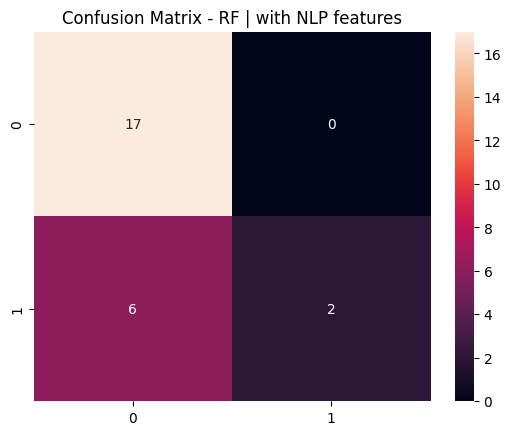

              precision    recall  f1-score   support

           0       0.74      1.00      0.85        17
           1       1.00      0.25      0.40         8

    accuracy                           0.76        25
   macro avg       0.87      0.62      0.62        25
weighted avg       0.82      0.76      0.71        25



In [ ]:
# Show confusion matrix and precision and recall values

sns.heatmap(confusion_matrix(y_test, rf.predict(X_test)), annot=True, fmt='d')
plt.title("Confusion Matrix - RF | with NLP features")
plt.show()

print(classification_report(y_test, rf.predict(X_test)))

***RF model still performing poorly compared to XGBoost***

### 10.2) Random Forest Model - Tuned

In [ ]:
# Hyperparameter distributions for random search

param_distributions = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

In [ ]:
# Set up random search

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='recall',              # Set to recall as we want to catch the EPS misses .
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1                      # use all processors
)

# Fit to data
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d3c39793210>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d3c3b013850>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d3c3a689610>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d3c4ac12d10>},
                   random_state=42, scoring='recall', verbose=1)

In [ ]:
# Best model and parameters
best_rf = random_search.best_estimator_
print("Best parameters found:", random_search.best_params_)

Best parameters found: {'bootstrap': False, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 18, 'n_estimators': 185}


In [ ]:
# Predict using the best model
y_pred = best_rf.predict(X_test)

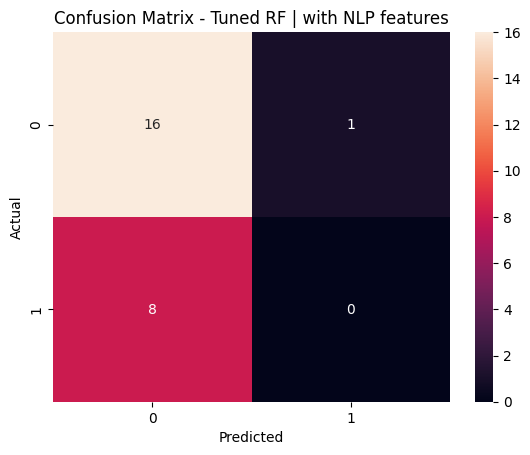

              precision    recall  f1-score   support

           0       0.67      0.94      0.78        17
           1       0.00      0.00      0.00         8

    accuracy                           0.64        25
   macro avg       0.33      0.47      0.39        25
weighted avg       0.45      0.64      0.53        25



In [ ]:
# Confusion Matrix for best RF model

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Confusion Matrix - Tuned RF | with NLP features")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_test, y_pred))

***RF model still performing poorly compared to XGBoost***

### 10.3) XG Boost Model

In [ ]:
# Initialise XGB model

xgb_clf = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    verbosity=0
)

In [ ]:
# Fit XGB Model

xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

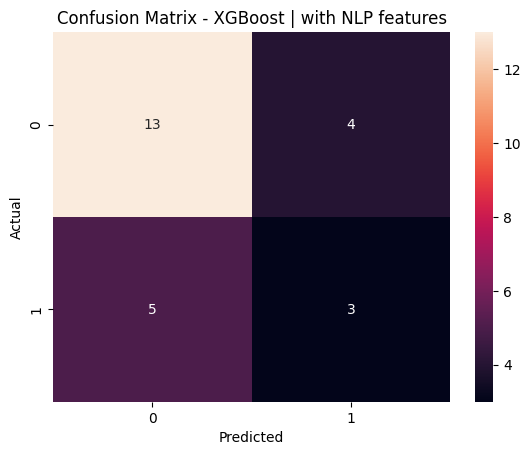

              precision    recall  f1-score   support

           0       0.72      0.76      0.74        17
           1       0.43      0.38      0.40         8

    accuracy                           0.64        25
   macro avg       0.58      0.57      0.57        25
weighted avg       0.63      0.64      0.63        25



In [ ]:
# Show confusion matrix for XGBoost

sns.heatmap(confusion_matrix(y_test, xgb_clf.predict(X_test)), annot=True, fmt='d')
plt.title("Confusion Matrix - XGBoost | with NLP features")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_test, xgb_clf.predict(X_test)))

***XGBoost is more promising than the Random Forest Model with higher recall and precision***

### 10.4) XG Boost Model - Tuned [BEST MODEL]

In [ ]:
# Initialise XGB

xgb_clf = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    verbosity=0
)

In [ ]:
# Class weight ratio

class_weight_ratio = (y_train == 0).sum() /  (y_train == 1).sum()
class_weight_ratio

np.float64(2.75)

In [ ]:
# Parameter grid for searching
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, class_weight_ratio, 2*class_weight_ratio]  # to handle the obvious class imbalance we have, also seeing if overweighting the positive class helps
}

In [ ]:
# Random search across param grid

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=20,  # number of parameter combinations to try
    scoring='recall',  # focusing on improving recall score - ideally we want to identify real misses/be cautious of potential negative earnings surprises
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 300],
                                        'scale_pos_weight': [1,
                                                             np.float64(2.75),
                                                             np.float64(5.5)],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='recall', verbose=1)

In [ ]:
# Best model and parameters
best_xgb = random_search.best_estimator_
print("Best parameters found:", random_search.best_params_)

Best parameters found: {'subsample': 0.6, 'scale_pos_weight': np.float64(5.5), 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.6}


In [ ]:
# Use the best XGB Model to predict
y_pred = best_xgb.predict(X_test)

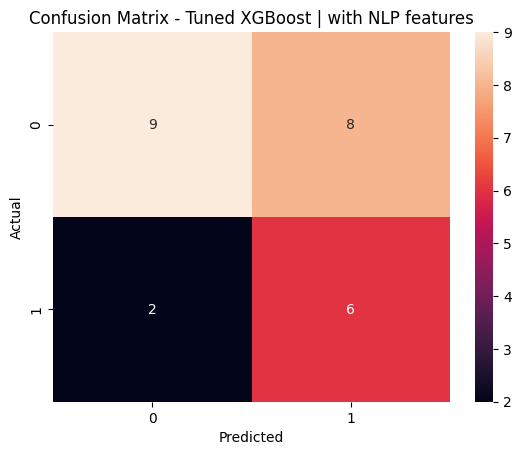

              precision    recall  f1-score   support

           0       0.82      0.53      0.64        17
           1       0.43      0.75      0.55         8

    accuracy                           0.60        25
   macro avg       0.62      0.64      0.59        25
weighted avg       0.69      0.60      0.61        25



In [ ]:
# Confusion matrix for the best XGB Model
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Confusion Matrix - Tuned XGBoost | with NLP features")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_test, y_pred))

***Adding NLP features has improved precision slightly (0.40 >> 0.43), whilst maintaining recall the same***

##### 10.4.1) Cross validation

In [ ]:
# Cross validation

# Remove warnings as they clutter the output
warnings.filterwarnings("ignore", message='.*use_label_encoder.*')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_xgb, X_train, y_train, cv=cv, scoring='recall')

print("CV Recall scores:", scores)
print("Mean Recall score:", np.mean(scores))
print("Recall std dev:", np.std(scores))

CV Recall scores: [0.66666667 0.33333333 0.         0.5        1.        ]
Mean Recall score: 0.5
Recall std dev: 0.33333333333333337


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_xgb, X_train, y_train, cv=cv, scoring='precision')

print("CV Precision scores:", scores)
print("Mean Precision score:", np.mean(scores))
print("Precision std dev:", np.std(scores))

CV Precision scores: [1.         0.33333333 0.         0.16666667 0.25      ]
Mean Precision score: 0.35
Precision std dev: 0.34318767136623335


***Cross validation standard deviations are high (and higher vs financial features only) as a result of small sample sizes - this can affect how robust this model is***

##### 10.4.2) SHAP plot

In [ ]:
shap.initjs()

# Get SHAP values
shap_ex = shap.TreeExplainer(best_xgb)
vals = shap_ex(X_test)

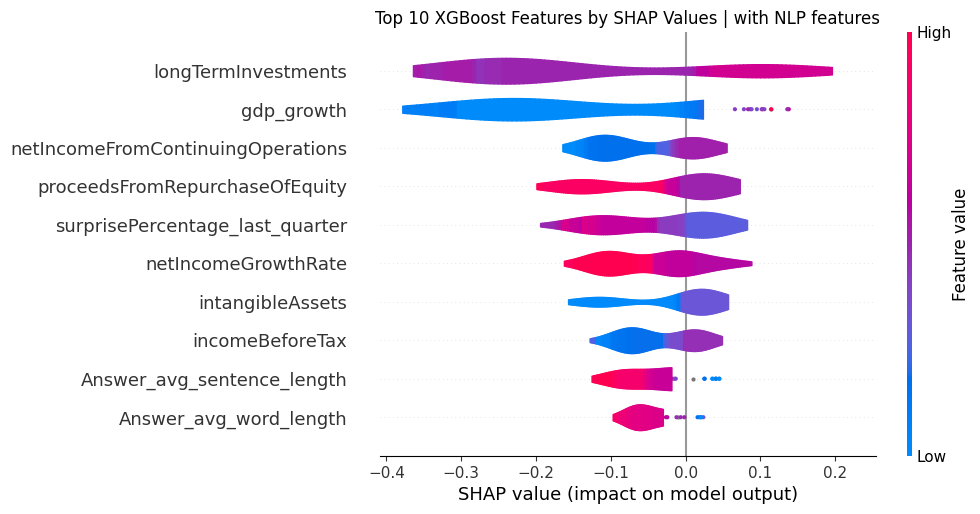

In [ ]:
# Violin plot of features

# Calculate mean absolute SHAP values per feature
mean_abs_shap = vals.abs.mean(0).values

# Get indices of top 10 features by mean absolute SHAP value
top10_idx = np.argsort(mean_abs_shap)[::-1][:10]

# Subset vals to top 10 features (this keeps the shape samples x 10)
top10_vals = shap.Explanation(
    values=vals.values[:, top10_idx],
    base_values=vals.base_values,
    data=vals.data[:, top10_idx],
    feature_names=[vals.feature_names[i] for i in top10_idx]
)

# Plot violin plot for the top 10 features
plt.title('Top 10 XGBoost Features by SHAP Values | with NLP features')
shap.plots.violin(top10_vals)
plt.show()

* Long term investments increases the likelihood of negative EPS surprise - this is perhaps because struggling banks try to improve their longer term trajectory by making investments
* Higher GDP growth tends to reduce the likelihood of negative EPS surprise, as growth drives bank profits
* High share buybacks decreases the likelihood of negative EPS surprise - banks would be unlikely to do this if they were in a poor financial situation and the reduction of shares leads to higher EPS in future periods

### 10.5) XGBoost Model - Tuned with fewer features

In [ ]:
# Top 20 features from XGBoost model with all features

importance_dict = best_xgb.get_booster().get_score(importance_type='gain')

# Convert to DataFrame
importance_df = pd.DataFrame(
    importance_dict.items(),
    columns=['feature', 'importance']
)

# Sort by importance (descending)
importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

# Top 20 features
importance_df[0:20]

feature  importance
0           totalCurrentLiabilities   21.774866
1               longTermInvestments   13.224679
2                    vagueness_rate   12.473626
3                       gunning_fog   11.437325
4                        smog_index   11.071383
5                    returnOnEquity   10.932755
6            currentAccountsPayable   10.808641
7                  intangibleAssets   10.205541
8    proceedsFromRepurchaseOfEquity    9.934545
9                        gdp_growth    9.850274
10                 federalFundsRate    9.672143
11  surprisePercentage_last_quarter    9.331385
12                      totalAssets    8.915500
13                   cashConversion    8.867801
14     commonStockSharesOutstanding    7.923092
15                operatingExpenses    7.857566
16                 interestCoverage    7.854243
17               fedFundsGrowthRate    7.801126
18                 shareBuybackRate    7.596511
19                     jargon_count    7.442270

In [ ]:
# Create copy of x_train with a smaller set of features from earlier model 8.6) AND all NLP features

smaller_feature_list_plus_nlp = smaller_feature_list + nlp_features

X_train_smaller = X_train[smaller_feature_list_plus_nlp]
X_test_smaller = X_test[smaller_feature_list_plus_nlp]

In [ ]:
# Random search across param grid

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=20,  # number of parameter combinations to try
    scoring='recall',  # focusing on improving recall score - ideally we want to identify real misses/be cautious of potential negative earnings surprises
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_smaller, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 300],
                                        'scale_pos_weight': [1,
                                                             np.float64(2.75),
                                                             np.float64(5.5)],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='recall', verbose=1)

In [ ]:
# Best model and parameters
best_xgb = random_search.best_estimator_
print("Best parameters found:", random_search.best_params_)

Best parameters found: {'subsample': 0.6, 'scale_pos_weight': np.float64(5.5), 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.6}


In [ ]:
# Use the best XGB Model to predict
y_pred = best_xgb.predict(X_test_smaller)

#### 10.5.1) Cross validation

In [ ]:
# Cross validation

# Remove warnings as they clutter the output
warnings.filterwarnings("ignore", message='.*use_label_encoder.*')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_xgb, X_train, y_train, cv=cv, scoring='recall')

print("CV Recall scores:", scores)
print("Mean Recall score:", np.mean(scores))
print("Recall std dev:", np.std(scores))

CV Recall scores: [0.66666667 0.33333333 0.         0.5        1.        ]
Mean Recall score: 0.5
Recall std dev: 0.33333333333333337


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_xgb, X_train, y_train, cv=cv, scoring='precision')

print("CV Precision scores:", scores)
print("Mean Precision score:", np.mean(scores))
print("Precision std dev:", np.std(scores))

CV Precision scores: [1.         0.33333333 0.         0.16666667 0.25      ]
Mean Precision score: 0.35
Precision std dev: 0.34318767136623335


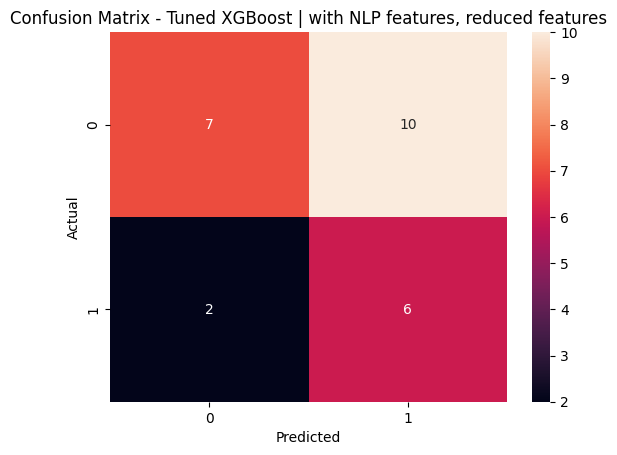

              precision    recall  f1-score   support

           0       0.78      0.41      0.54        17
           1       0.38      0.75      0.50         8

    accuracy                           0.52        25
   macro avg       0.58      0.58      0.52        25
weighted avg       0.65      0.52      0.53        25



In [ ]:
# Confusion matrix for the best XGB Model
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Confusion Matrix - Tuned XGBoost | with NLP features, reduced features")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_test, y_pred))

#### 10.5.2) SHAP Plot

In [ ]:
shap.initjs()

# Get SHAP values
shap_ex = shap.TreeExplainer(best_xgb)
vals = shap_ex(X_test_smaller)

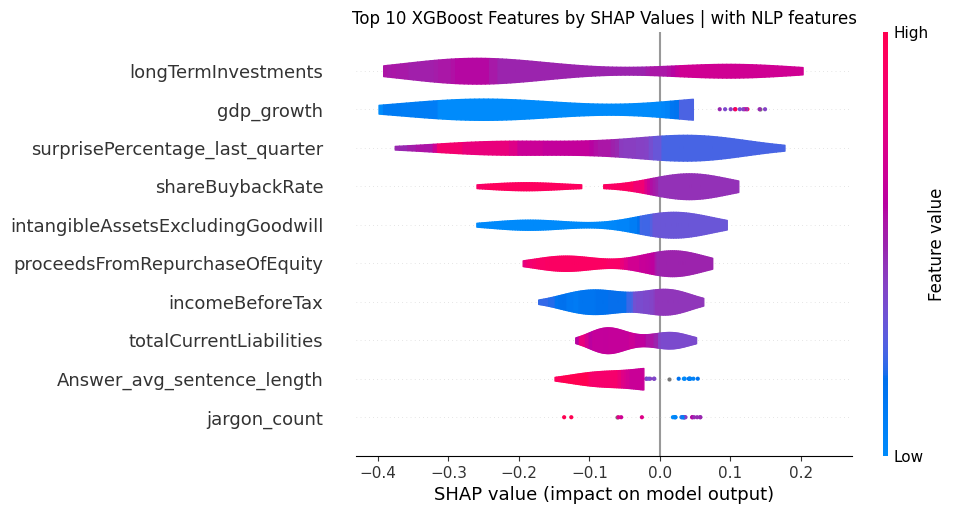

In [ ]:
# Violin plot of features

# Calculate mean absolute SHAP values per feature
mean_abs_shap = vals.abs.mean(0).values

# Get indices of top 10 features by mean absolute SHAP value
top10_idx = np.argsort(mean_abs_shap)[::-1][:10]

# Subset vals to top 10 features (this keeps the shape samples x 10)
top10_vals = shap.Explanation(
    values=vals.values[:, top10_idx],
    base_values=vals.base_values,
    data=vals.data[:, top10_idx],
    feature_names=[vals.feature_names[i] for i in top10_idx]
)

# Plot violin plot for the top 10 features
plt.title('Top 10 XGBoost Features by SHAP Values | with NLP features')
shap.plots.violin(top10_vals)
plt.show()

## 11) Model: Prediction of Continuous EPS Metric

Whilst the orginal outcome specification was using a binary outcome variable for low/negative EPS vs expectations (as we are most interested in misses), we are checking the continuous variable as a way of adding additional evidence as to whether adding NLP features is more generally beneficial in predicting EPS vs expectation. Continuous outcome variables have more variance and are better able to detect impacts of additional features with small sample sizes

#### 11.1) XGBoost Regression Model - Financial features only

In [ ]:
# Split dataset

X = combined_df.drop(columns=['surprisePercentage', 'is_neg_surprise', 'is_neg_surprise_adj'])
y = combined_df['surprisePercentage']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
# Initialise XGB model

xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',  # Standard regression
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [ ]:
# Fit XGB regressor model

xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Predict using fitted model

y_pred = xgb_reg.predict(X_test)

In [ ]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")

MAE: 6.9964
RMSE: 10.2215
R-squared: 0.6338


In [ ]:
# Plot true vs predicted values

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7, label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal (y=x)')
plt.xlabel('True Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('True vs. Predicted Values - XGBoost Model - Tuned with ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Cross validation

model = xgb.XGBRegressor(random_state=42)

scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)

# Convert negative RMSE to positive values

rmse_scores = -scores
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)

# Print results
print(f"RMSE scores for each fold: {rmse_scores}")
print(f"Mean RMSE: {mean_rmse:.2f}")
print(f"Standard Deviation of RMSE: {std_rmse:.2f}")

RMSE scores for each fold: [11.35749982 12.64522968 15.89919683 18.46216825  7.04911529]
Mean RMSE: 13.08
Standard Deviation of RMSE: 3.91


#### 11.2) XGBoost Regression Model - Financial and NLP features

In [ ]:
# Split dataset

X = combined_df_nlp.drop(columns=['surprisePercentage', 'is_neg_surprise', 'is_neg_surprise_adj'])
y = combined_df_nlp['surprisePercentage']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
# Initialise XGB model

xgb_reg = xgb.XGBRegressor(
    eval_metric='logloss',
    random_state=42
)

In [ ]:
# Fit XGB regressor model

xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='logloss',
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Predict using fitted model

y_pred = xgb_reg.predict(X_test)

In [ ]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")

MAE: 7.2721
RMSE: 11.3469
R-squared: 0.5487


In [ ]:
# Plot true vs predicted values

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7, label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal (y=x)')
plt.xlabel('True Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('True vs. Predicted Values - XGBoost Model - Tuned with ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Cross validation

model = xgb.XGBRegressor(random_state=42)

scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)

# Convert negative RMSE to positive values

rmse_scores = -scores
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)

# Print results
print(f"RMSE scores for each fold: {rmse_scores}")
print(f"Mean RMSE: {mean_rmse:.2f}")
print(f"Standard Deviation of RMSE: {std_rmse:.2f}")

RMSE scores for each fold: [11.66859315 13.07572851 17.13364731 18.91841586  7.57226454]
Mean RMSE: 13.67
Standard Deviation of RMSE: 4.03


The model fits slightly better without the NLP features, however the difference is very small. A future iteration would investigate whether the models are influenced by the outlier outcome datapoints